# House Rent Prediction - Full Data Science Pipeline

This notebook demonstrates the complete workflow for predicting house rent prices using Linear Regression.


In [250]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

import warnings
warnings.filterwarnings('ignore')


## 1. Data Loading & Exploration


In [251]:
# Load raw data
df_raw = pd.read_csv("Data/rent.csv")
print(f"Dataset shape: {df_raw.shape}")
print(f"\nColumns: {list(df_raw.columns)}")
df_raw.head()


Dataset shape: (4746, 12)

Columns: ['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']


,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [252]:
# Data types and missing values
print("Data Types:")
print(df_raw.dtypes)
print(f"\nMissing Values:\n{df_raw.isnull().sum()}")


Data Types:
Posted On            object
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
dtype: object

Missing Values:
Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64


### 1.1 Target Variable Distribution (Rent)


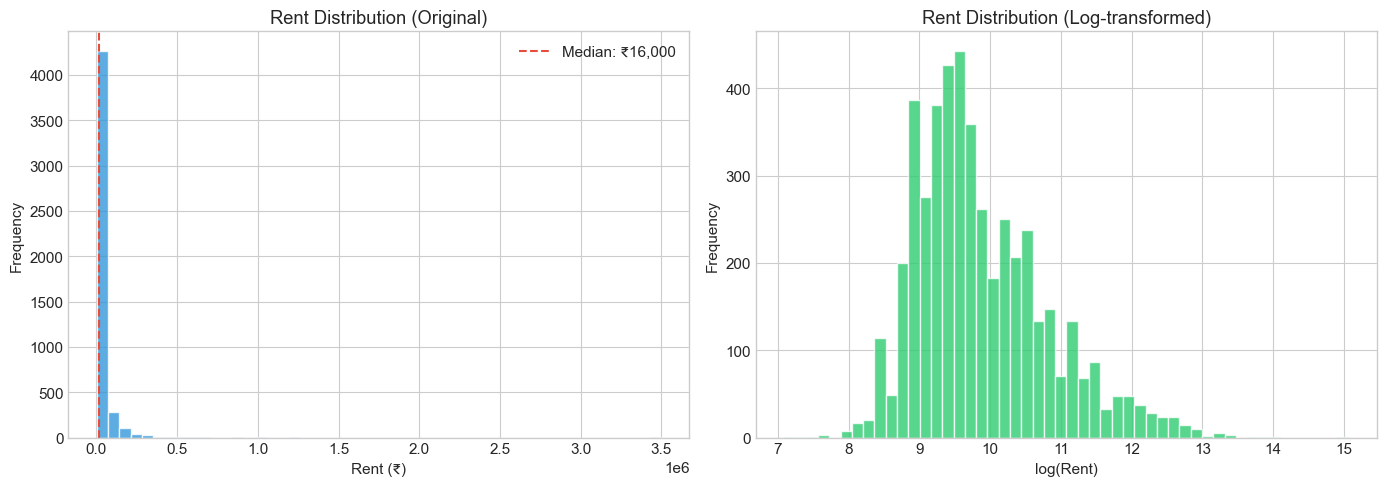

Rent Statistics:
  Min: ₹1,200
  Max: ₹3,500,000
  Mean: ₹34,993
  Median: ₹16,000


In [253]:
# Rent distribution - before and after log transform
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
axes[0].hist(df_raw['Rent'], bins=50, color='#3498db', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('Rent (₹)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Rent Distribution (Original)')
axes[0].axvline(df_raw['Rent'].median(), color='#e74c3c', linestyle='--', label=f"Median: ₹{df_raw['Rent'].median():,.0f}")
axes[0].legend()

# Log-transformed distribution
axes[1].hist(np.log(df_raw['Rent']), bins=50, color='#2ecc71', edgecolor='white', alpha=0.8)
axes[1].set_xlabel('log(Rent)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Rent Distribution (Log-transformed)')

plt.tight_layout()
plt.show()

print(f"Rent Statistics:")
print(f"  Min: ₹{df_raw['Rent'].min():,}")
print(f"  Max: ₹{df_raw['Rent'].max():,}")
print(f"  Mean: ₹{df_raw['Rent'].mean():,.0f}")
print(f"  Median: ₹{df_raw['Rent'].median():,.0f}")


### 1.2 Categorical Features Distribution


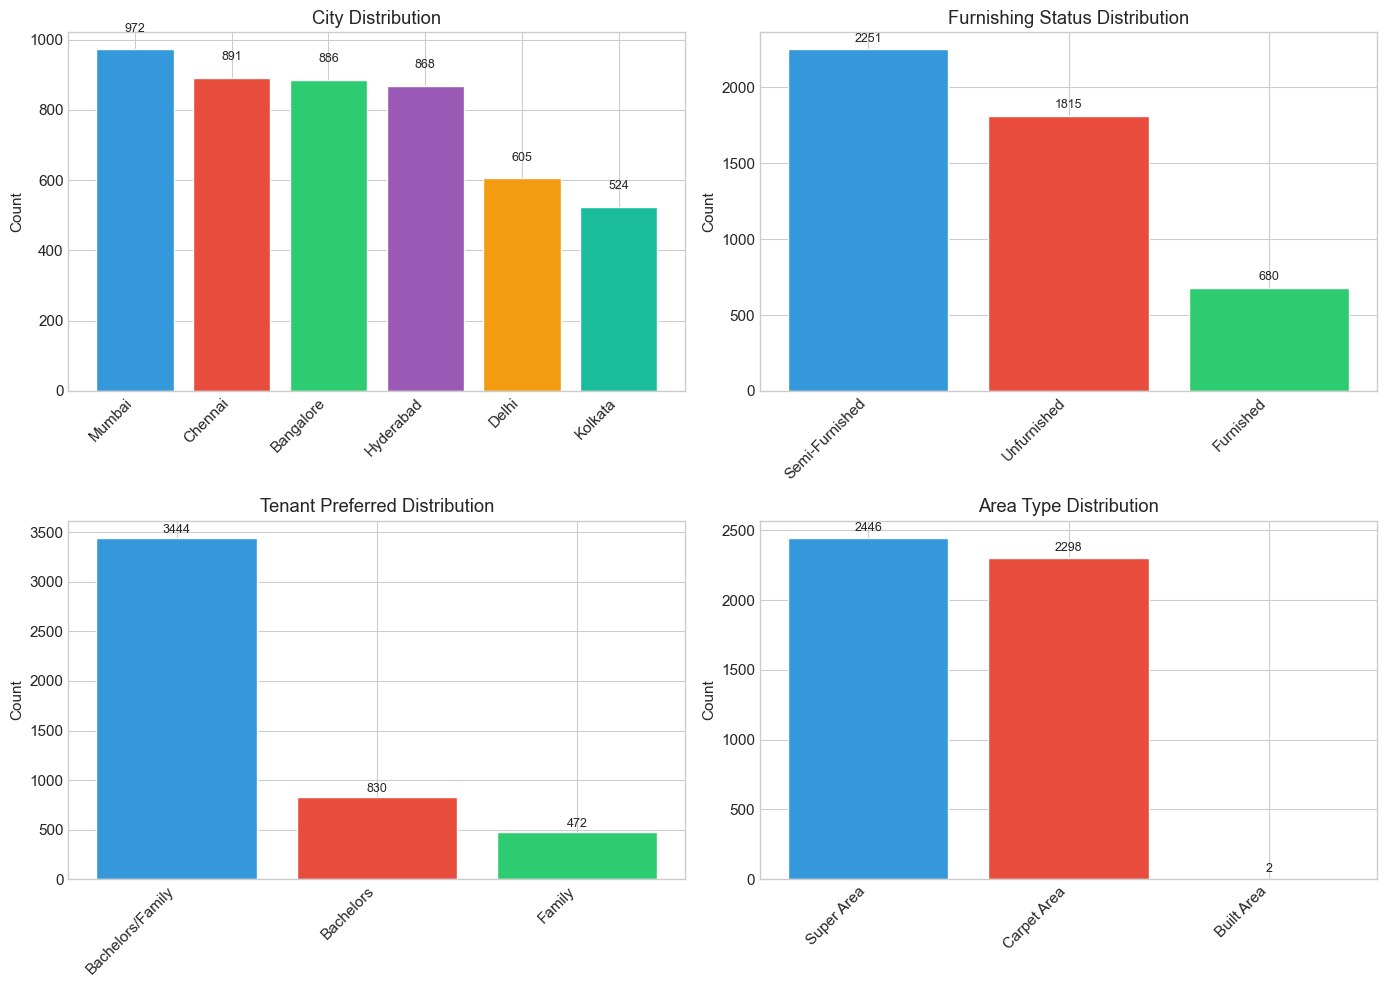

In [254]:
# Categorical features distribution
cat_features = ['City', 'Furnishing Status', 'Tenant Preferred', 'Area Type']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']

for i, col in enumerate(cat_features):
    value_counts = df_raw[col].value_counts()
    axes[i].bar(range(len(value_counts)), value_counts.values, color=colors[:len(value_counts)], edgecolor='white')
    axes[i].set_xticks(range(len(value_counts)))
    axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_ylabel('Count')
    
    # Add count labels
    for j, v in enumerate(value_counts.values):
        axes[i].text(j, v + 50, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()


### 1.3 Rent by City (Box Plot)


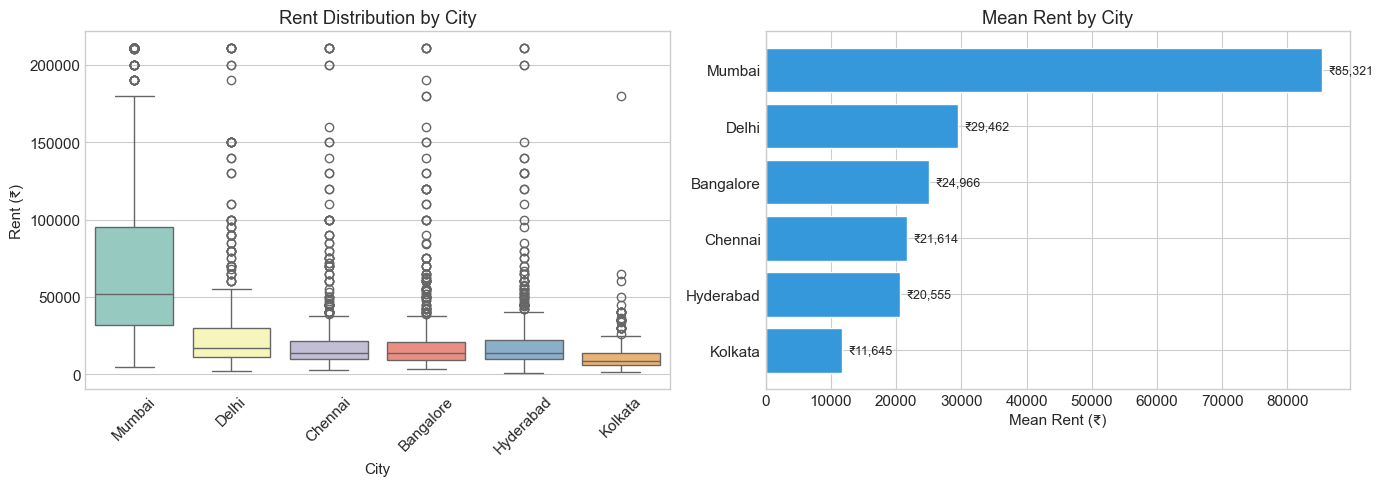

In [255]:
# Rent by City
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
city_order = df_raw.groupby('City')['Rent'].median().sort_values(ascending=False).index
upper = df_raw['Rent'].quantile(0.98)
df_plot = df_raw.copy()
df_plot['Rent_capped'] = df_plot['Rent'].clip(upper=upper)

sns.boxplot(
    data=df_plot,
    x='City',
    y='Rent_capped',
    order=city_order,
    ax=axes[0],
    palette='Set3'
)
axes[0].set_title('Rent Distribution by City')
axes[0].set_ylabel('Rent (₹)')
axes[0].tick_params(axis='x', rotation=45)

# Mean rent by city
city_means = df_raw.groupby('City')['Rent'].mean().sort_values(ascending=True)
axes[1].barh(city_means.index, city_means.values, color='#3498db', edgecolor='white')
axes[1].set_xlabel('Mean Rent (₹)')
axes[1].set_title('Mean Rent by City')

# Add value labels
for i, v in enumerate(city_means.values):
    axes[1].text(v + 1000, i, f'₹{v:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()


### 1.4 Size vs Rent Relationship


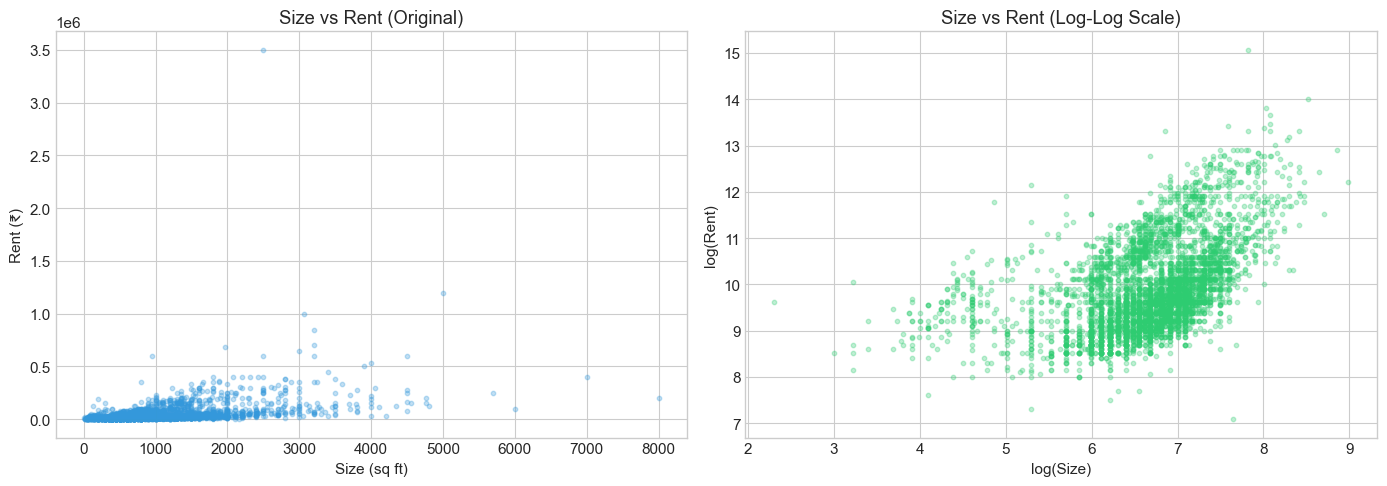

Correlation (Size, Rent): 0.4136
Correlation (log(Size), log(Rent)): 0.4862


In [256]:
# Size vs Rent scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original scale
axes[0].scatter(df_raw['Size'], df_raw['Rent'], alpha=0.3, c='#3498db', s=10)
axes[0].set_xlabel('Size (sq ft)')
axes[0].set_ylabel('Rent (₹)')
axes[0].set_title('Size vs Rent (Original)')

# Log-log scale
axes[1].scatter(np.log(df_raw['Size']), np.log(df_raw['Rent']), alpha=0.3, c='#2ecc71', s=10)
axes[1].set_xlabel('log(Size)')
axes[1].set_ylabel('log(Rent)')
axes[1].set_title('Size vs Rent (Log-Log Scale)')

plt.tight_layout()
plt.show()

print(f"Correlation (Size, Rent): {df_raw['Size'].corr(df_raw['Rent']):.4f}")
print(f"Correlation (log(Size), log(Rent)): {np.log(df_raw['Size']).corr(np.log(df_raw['Rent'])):.4f}")


### 1.5 Correlation Matrix


## 2. Data Preprocessing


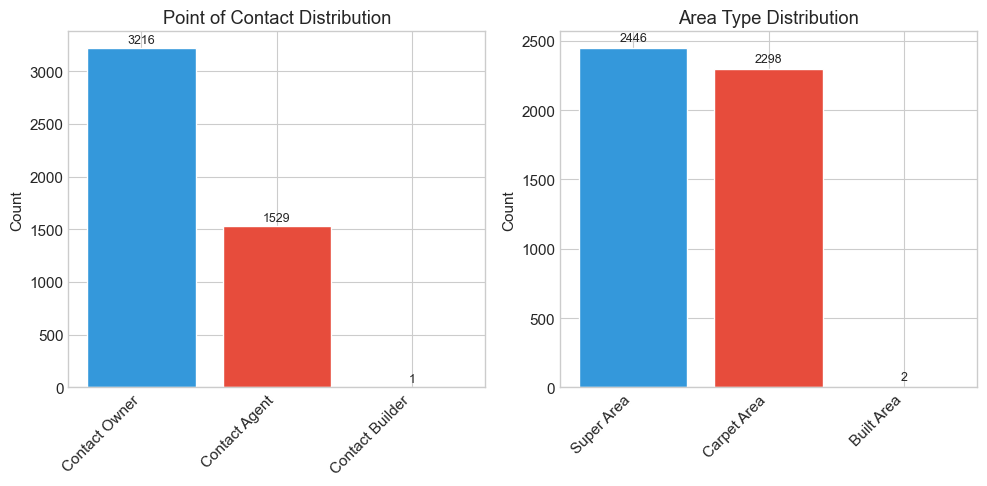

In [257]:
# Categorical features distribution
cat_features = ['Point of Contact', 'Area Type']


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']

for i, col in enumerate(cat_features):
    value_counts = df_raw[col].value_counts()
    axes[i].bar(range(len(value_counts)), value_counts.values, color=colors[:len(value_counts)], edgecolor='white')
    axes[i].set_xticks(range(len(value_counts)))
    axes[i].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_ylabel('Count')
    
    # Add count labels
    for j, v in enumerate(value_counts.values):
        axes[i].text(j, v + 50, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

Original dataset size: 4746
After 1-99 percentile filter (₹4,000 - ₹300,000): 4671
Dropped columns: ['Area Locality', 'Point of Contact', 'Area Type']
Remaining columns: ['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom']


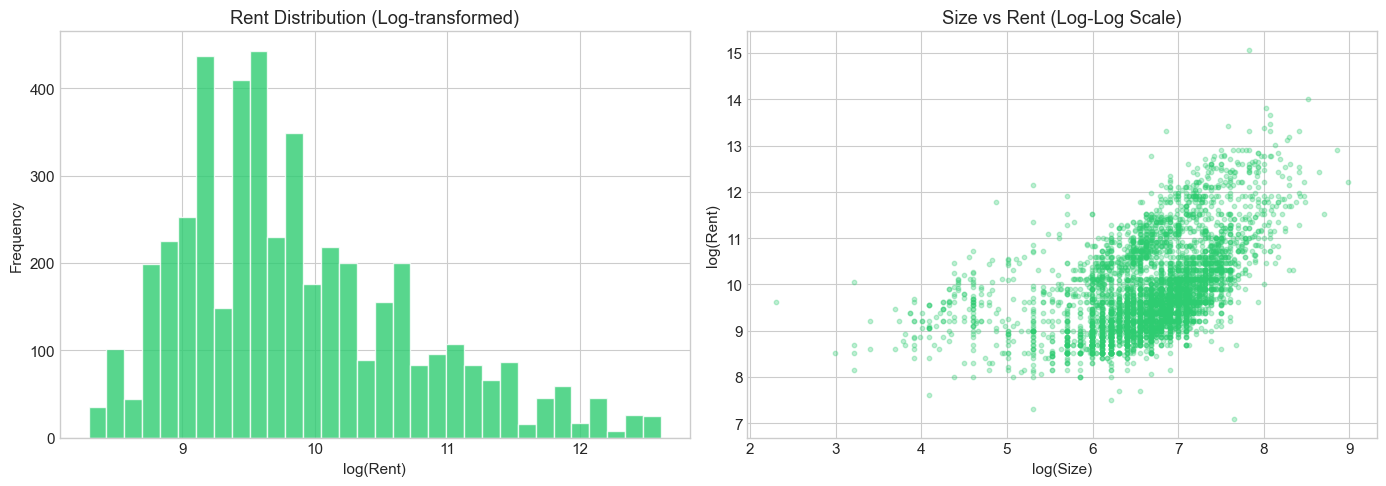

In [258]:
# Start with raw data copy
df = df_raw.copy()
print(f"Original dataset size: {len(df)}")

remove_part = 0.01
# Remove outliers using 1-99 percentiles
lower_bound = df['Rent'].quantile(remove_part)
upper_bound = df['Rent'].quantile(1 - remove_part)
df = df[(df['Rent'] >= lower_bound) & (df['Rent'] <= upper_bound)]
print(f"After {remove_part*100:.0f}-{(1-remove_part)*100:.0f} percentile filter (₹{lower_bound:,.0f} - ₹{upper_bound:,.0f}): {len(df)}")

# Drop unnecessary columns
columns_to_drop = ['Area Locality', 'Point of Contact', 'Area Type']
df = df.drop(columns=columns_to_drop)
print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining columns: {list(df.columns)}")

# Log-transformed distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(np.log(df['Rent']), bins="auto", color='#2ecc71', edgecolor='white', alpha=0.8)
axes[0].set_xlabel('log(Rent)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Rent Distribution (Log-transformed)')
# Log-log scale
axes[1].scatter(np.log(df_raw['Size']), np.log(df_raw['Rent']), alpha=0.3, c='#2ecc71', s=10)
axes[1].set_xlabel('log(Size)')
axes[1].set_ylabel('log(Rent)')
axes[1].set_title('Size vs Rent (Log-Log Scale)')

plt.tight_layout()
plt.show()

### 2.1 Floor Column Parsing


In [259]:
# Parse Floor column: "2 out of 5" -> Floor Level = 2, Total Floors = 5
print("Sample Floor values:", df['Floor'].head(10).tolist())

def process_floor_column(df):
    """Parse Floor column into Floor Level and Total Floors."""
    df = df.copy()
    
    split_floor = df['Floor'].str.split(' out of ', expand=True)
    df['Floor Level'] = split_floor[0]
    df['Total Floors'] = split_floor[1]
    
    # Handle special floor names
    df['Floor Level'] = df['Floor Level'].replace({
        'Ground': 0,
        'Lower Basement': -1,
        'Upper Basement': -2
    })
    
    df['Floor Level'] = pd.to_numeric(df['Floor Level'], errors='coerce')
    df['Total Floors'] = pd.to_numeric(df['Total Floors'], errors='coerce')
    
    # Fill missing with median
    df['Floor Level'] = df['Floor Level'].fillna(df['Floor Level'].median())
    df['Total Floors'] = df['Total Floors'].fillna(df['Total Floors'].median())
    
    df = df.drop(['Floor'], axis=1)
    return df

df = process_floor_column(df)
print(f"\nAfter parsing Floor column:")
print(df[['Floor Level', 'Total Floors']].describe())


Sample Floor values: ['Ground out of 2', '1 out of 3', '1 out of 3', '1 out of 2', '1 out of 2', 'Ground out of 1', 'Ground out of 4', '1 out of 2', '1 out of 2', '1 out of 3']

After parsing Floor column:
       Floor Level  Total Floors
count  4671.000000   4671.000000
mean      3.368230      6.850567
std       5.606295      9.135357
min      -2.000000      1.000000
25%       1.000000      2.000000
50%       2.000000      4.000000
75%       3.000000      6.000000
max      76.000000     89.000000


### 2.2 Date Features Engineering


Date features created:
  day of week posted: [2 4 0 1 5 3 6]
  quarter posted: [2 3]


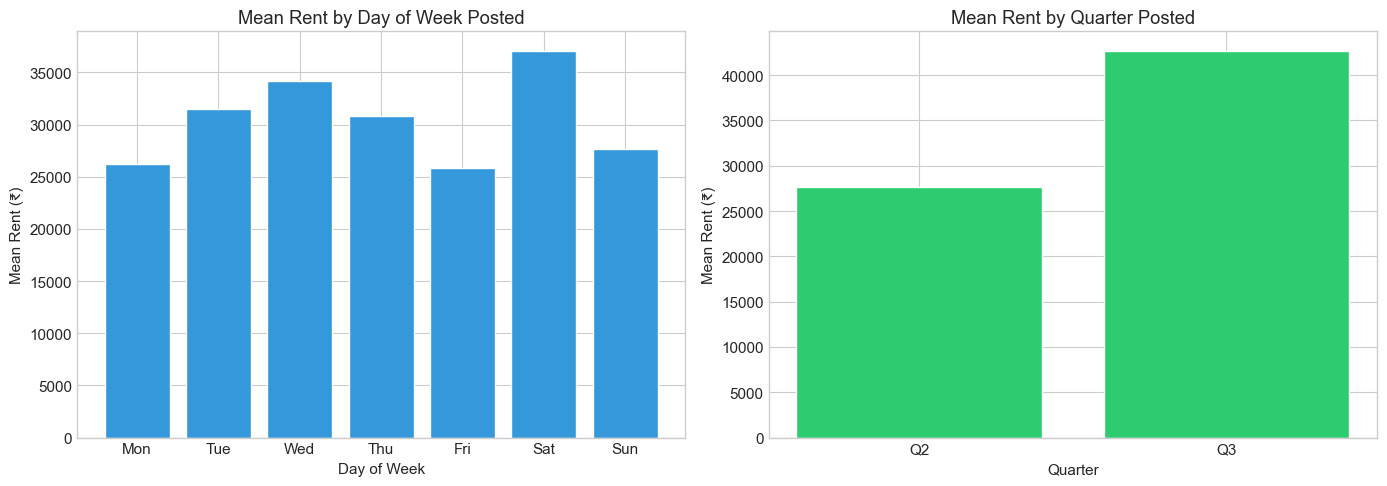

In [260]:
# Extract date features from Posted On
df['Posted On'] = pd.to_datetime(df['Posted On'])
df['day of week posted'] = df['Posted On'].dt.day_of_week
df['quarter posted'] = df['Posted On'].dt.quarter
df = df.drop('Posted On', axis=1)

print("Date features created:")
print(f"  day of week posted: {df['day of week posted'].unique()}")
print(f"  quarter posted: {df['quarter posted'].unique()}")

# Visualize date features vs rent
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Day of week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_means = df.groupby('day of week posted')['Rent'].mean()
axes[0].bar(day_names, day_means.values, color='#3498db', edgecolor='white')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Mean Rent (₹)')
axes[0].set_title('Mean Rent by Day of Week Posted')

# Quarter
quarter_means = df.groupby('quarter posted')['Rent'].mean()
axes[1].bar([f'Q{q}' for q in quarter_means.index], quarter_means.values, color='#2ecc71', edgecolor='white')
axes[1].set_xlabel('Quarter')
axes[1].set_ylabel('Mean Rent (₹)')
axes[1].set_title('Mean Rent by Quarter Posted')

plt.tight_layout()
plt.show()


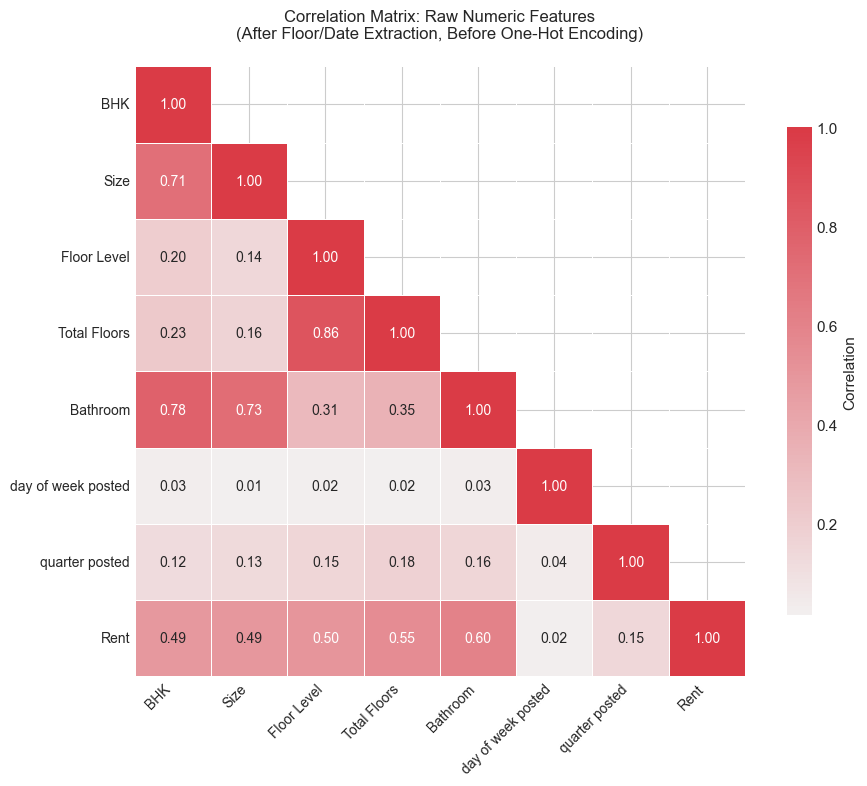


Top correlations with Rent:
  Bathroom: 0.6032
  Total Floors: 0.5505
  Floor Level: 0.5008
  Size: 0.4923
  BHK: 0.4883
  quarter posted: 0.1478
  day of week posted: 0.0193

Top feature-feature correlations:
  Floor Level ↔ Total Floors: 0.8562
  BHK ↔ Bathroom: 0.7832
  Size ↔ Bathroom: 0.7264
  BHK ↔ Size: 0.7062
  Total Floors ↔ Bathroom: 0.3465


In [261]:
# ============================================
# Correlation Matrix - Raw Numeric Features (Before One-Hot Encoding)
# ============================================
# Select only numeric columns for correlation analysis
numeric_cols_raw = ['BHK', 'Size', 'Floor Level', 'Total Floors', 'Bathroom', 
                    'day of week posted', 'quarter posted', 'Rent']

df_numeric = df[numeric_cols_raw].copy()

# Compute correlation matrix
corr_raw = df_numeric.corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))

mask = np.triu(np.ones_like(corr_raw, dtype=bool), k=1)
cmap = sns.diverging_palette(250, 10, as_cmap=True)

sns.heatmap(
    corr_raw,
    mask=mask,
    cmap=cmap,
    center=0,
    annot=True,
    fmt='.2f',
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation'},
    annot_kws={'size': 10},
    ax=ax
)

ax.set_title('Correlation Matrix: Raw Numeric Features\n(After Floor/Date Extraction, Before One-Hot Encoding)', 
             fontsize=12, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Print top correlations
print("\nTop correlations with Rent:")
rent_corr = corr_raw['Rent'].drop('Rent').sort_values(key=abs, ascending=False)
for feat, val in rent_corr.items():
    print(f"  {feat}: {val:.4f}")

print("\nTop feature-feature correlations:")
n = len(corr_raw.columns)
pairs = []
for i in range(n):
    for j in range(i + 1, n):
        if corr_raw.columns[i] != 'Rent' and corr_raw.columns[j] != 'Rent':
            pairs.append({
                'pair': f"{corr_raw.columns[i]} ↔ {corr_raw.columns[j]}",
                'corr': corr_raw.iat[i, j]
            })
top_pairs = sorted(pairs, key=lambda x: abs(x['corr']), reverse=True)[:5]
for p in top_pairs:
    print(f"  {p['pair']}: {p['corr']:.4f}")


## 3. Train/Test Split & Feature Engineering


In [262]:
# Train/Test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# Separate features and target
target_column = 'Rent'
X_train = train_df.drop(columns=[target_column])
y_train = np.log(train_df[target_column])  # Log transform target

X_test = test_df.drop(columns=[target_column])
y_test = np.log(test_df[target_column])

print(f"\nFeatures shape: {X_train.shape}")
print(f"Features: {list(X_train.columns)}")


Train size: 3736, Test size: 935

Features shape: (3736, 10)
Features: ['BHK', 'Size', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Floor Level', 'Total Floors', 'day of week posted', 'quarter posted']


### 3.1 Column Transformer (Log Scaling + One-Hot Encoding)


In [263]:
# ============================================
# Configuration from config.py
# ============================================
LOG_SCALING_COLS = ['Size']
NUMERIC_COLS = ['Floor Level', 'Total Floors', 'BHK', 'Bathroom']
CATEGORICAL_COLS = ['City', 'Furnishing Status', 'Tenant Preferred', 'day of week posted', 'quarter posted']

# Interaction combinations (empty = no combinations)
COMBINATIONS_TO_APPLY = [
    # {'columns': ['City', 'quarter posted', 'Tenant Preferred'], 'keep_originals': False},
]

# Pretty names for feature display
PRETTY_NAMES = {
    'day of week posted': {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun',
                          '0': 'Mon', '1': 'Tue', '2': 'Wed', '3': 'Thu', '4': 'Fri', '5': 'Sat', '6': 'Sun'},
    'quarter posted': {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4', '1': 'Q1', '2': 'Q2', '3': 'Q3', '4': 'Q4'}
}

COLUMN_SHORT_NAMES = {
    'day of week posted': 'Day',
    'quarter posted': 'Quarter',
    'Furnishing Status': 'Furnishing',
    'Tenant Preferred': 'Tenant',
}

def prettify_value(col_name, value):
    if col_name in PRETTY_NAMES:
        pretty = PRETTY_NAMES[col_name].get(value)
        if pretty:
            return pretty
    return str(value)

def prettify_col_name(col_name):
    return COLUMN_SHORT_NAMES.get(col_name, col_name)

# ============================================
# CombinedOneHotEncoder from combined_onehot_encoder.py
# ============================================
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import product

def joint_one_hot(X, sizes):
    N = X.shape[0]
    split_points = np.cumsum(sizes[:-1])
    groups = np.split(X, split_points, axis=1)
    indices = [np.argmax(g, axis=1) for g in groups]
    multipliers = np.cumprod(sizes[::-1])[::-1]
    multipliers = np.append(multipliers[1:], 1)
    joint_index = sum(idx * m for idx, m in zip(indices, multipliers))
    joint = np.zeros((N, np.prod(sizes)), dtype=int)
    joint[np.arange(N), joint_index] = 1
    return joint

class CombinedOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, column_indices, sizes, keep_originals=False):
        self.column_indices = column_indices
        self.sizes = sizes
        self.keep_originals = keep_originals
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = np.array(X)
        columns_to_combine = X[:, self.column_indices]
        combined = joint_one_hot(columns_to_combine, self.sizes)
        if self.keep_originals:
            result = np.hstack([X, combined])
        else:
            all_indices = set(range(X.shape[1]))
            indices_to_keep = sorted(all_indices - set(self.column_indices))
            X_remaining = X[:, indices_to_keep]
            result = np.hstack([X_remaining, combined])
        return result

# ============================================
# LogScaling transformer
# ============================================
class LogScaling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.log(X)

# ============================================
# Build preprocessing pipeline
# ============================================
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("log_transform", LogScaling(), LOG_SCALING_COLS),
    ("num_pipeline", num_pipeline, NUMERIC_COLS),
    ("cat_pipelines", cat_pipeline, CATEGORICAL_COLS)
], remainder='passthrough')

# Fit and transform
X_train_arr = preprocessor.fit_transform(X_train)
X_test_arr = preprocessor.transform(X_test)
print(f"After preprocessing: {X_train_arr.shape}")

# ============================================
# Get one-hot groups for combinations
# ============================================
def get_onehot_groups(preprocessor, log_cols, num_cols, cat_cols):
    start_idx = len(log_cols) + len(num_cols)
    ohe = preprocessor.named_transformers_['cat_pipelines'].named_steps['one_hot_encoder']
    onehot_groups = {}
    for col_name, categories in zip(cat_cols, ohe.categories_):
        size = len(categories)
        onehot_groups[col_name] = {'start': start_idx, 'size': size}
        start_idx += size
    return onehot_groups

onehot_groups = get_onehot_groups(preprocessor, LOG_SCALING_COLS, NUMERIC_COLS, CATEGORICAL_COLS)
print(f"OneHot groups: {onehot_groups}")

# ============================================
# Apply combinations (if any)
# ============================================
combiners = []
combined_groups = {}

for combo_config in COMBINATIONS_TO_APPLY:
    combo = combo_config['columns']
    keep_originals = combo_config.get('keep_originals', False)
    
    indices = []
    sizes = []
    for group_name in combo:
        group = onehot_groups[group_name]
        indices.extend(range(group['start'], group['start'] + group['size']))
        sizes.append(group['size'])
    
    print(f"Combining: {combo}, sizes={sizes}, keep_originals={keep_originals}")
    combiner = CombinedOneHotEncoder(column_indices=indices, sizes=sizes, keep_originals=keep_originals)
    X_train_arr = combiner.fit_transform(X_train_arr)
    X_test_arr = combiner.transform(X_test_arr)
    combiners.append(combiner)
    
    combined_size = np.prod(sizes)
    combined_start = X_train_arr.shape[1] - combined_size
    combined_name = ' x '.join(combo)
    combined_groups[combined_name] = {'start': combined_start, 'size': combined_size}
    
    if not keep_originals:
        for group_name in combo:
            del onehot_groups[group_name]
        indices_set = set(indices)
        for name, group in onehot_groups.items():
            removed_before = sum(1 for idx in indices_set if idx < group['start'])
            group['start'] = group['start'] - removed_before
        for name, group in combined_groups.items():
            if name != combined_name:
                removed_before = sum(1 for idx in indices_set if idx < group['start'])
                group['start'] = group['start'] - removed_before
    
    print(f"After combining: shape={X_train_arr.shape}")

# ============================================
# Drop first column from each one-hot group (dummy variable trap)
# ============================================
all_groups = {**onehot_groups, **combined_groups}
columns_to_drop = [group['start'] for group in all_groups.values()]
columns_to_drop = sorted(columns_to_drop, reverse=True)

for col_idx in columns_to_drop:
    X_train_arr = np.delete(X_train_arr, col_idx, axis=1)
    X_test_arr = np.delete(X_test_arr, col_idx, axis=1)

print(f"After dropping first of each group: {X_train_arr.shape}")

# ============================================
# Generate feature names (with pretty names)
# ============================================
ohe = preprocessor.named_transformers_['cat_pipelines'].named_steps['one_hot_encoder']
cat_col_to_categories = dict(zip(CATEGORICAL_COLS, ohe.categories_))

feature_names = []
feature_names.extend([f'log({col})' for col in LOG_SCALING_COLS])
feature_names.extend(NUMERIC_COLS)

# Remaining one-hot groups
removed_cols = [item for combo_config in COMBINATIONS_TO_APPLY 
               for item in combo_config['columns'] 
               if not combo_config.get('keep_originals', False)]
remaining_cat_cols = [c for c in CATEGORICAL_COLS if c not in removed_cols]

for col in remaining_cat_cols:
    categories = cat_col_to_categories[col]
    short_col = prettify_col_name(col)
    for cat in categories[1:]:  # Skip first (dropped for dummy trap)
        pretty_val = prettify_value(col, cat)
        feature_names.append(f'{short_col}: {pretty_val}')

# Combined group names
for combo_config in COMBINATIONS_TO_APPLY:
    combo = combo_config['columns']
    combo_categories = [cat_col_to_categories[c] for c in combo]
    all_combos = list(product(*combo_categories))
    for combo_vals in all_combos[1:]:  # Skip first
        parts = []
        for c, v in zip(combo, combo_vals):
            short_col = prettify_col_name(c)
            pretty_val = prettify_value(c, v)
            parts.append(f'{short_col}={pretty_val}')
        feature_names.append(' & '.join(parts))

print(f"\nTotal features: {len(feature_names)}")
print(f"Feature names: {feature_names}")


After preprocessing: (3736, 26)
OneHot groups: {'City': {'start': 5, 'size': 6}, 'Furnishing Status': {'start': 11, 'size': 3}, 'Tenant Preferred': {'start': 14, 'size': 3}, 'day of week posted': {'start': 17, 'size': 7}, 'quarter posted': {'start': 24, 'size': 2}}
After dropping first of each group: (3736, 21)

Total features: 21
Feature names: ['log(Size)', 'Floor Level', 'Total Floors', 'BHK', 'Bathroom', 'City: Chennai', 'City: Delhi', 'City: Hyderabad', 'City: Kolkata', 'City: Mumbai', 'Furnishing: Semi-Furnished', 'Furnishing: Unfurnished', 'Tenant: Bachelors/Family', 'Tenant: Family', 'Day: Tue', 'Day: Wed', 'Day: Thu', 'Day: Fri', 'Day: Sat', 'Day: Sun', 'Quarter: Q3']


### 3.2 Feature-Engineered Data Preview

In [264]:
# Create DataFrame with feature names for display
X_train_df = pd.DataFrame(X_train_arr, columns=feature_names)
X_test_df = pd.DataFrame(X_test_arr, columns=feature_names)

print(f"Training set shape: {X_train_df.shape}")
print(f"Test set shape: {X_test_df.shape}")
print(f"\nFeature-engineered data (first 10 rows of test set):")
X_test_df.head(10)


Training set shape: (3736, 21)
Test set shape: (935, 21)

Feature-engineered data (first 10 rows of test set):


,log(Size),Floor Level,Total Floors,BHK,Bathroom,City: Chennai,City: Delhi,City: Hyderabad,City: Kolkata,City: Mumbai,...,Furnishing: Unfurnished,Tenant: Bachelors/Family,Tenant: Family,Day: Tue,Day: Wed,Day: Thu,Day: Fri,Day: Sat,Day: Sun,Quarter: Q3
0,6.396930,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6.396930,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,7.003065,4.0,4.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,4.219508,3.0,5.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.047517,5.0,6.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,7.313220,23.0,34.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6,6.856462,6.0,7.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,6.907755,2.0,5.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,7.130899,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,6.109248,6.0,12.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 4. Model Training & Evaluation


In [265]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_arr, y_train)

# Predictions (in log scale)
y_train_pred_log = model.predict(X_train_arr)
y_test_pred_log = model.predict(X_test_arr)

# Convert predictions back to original scale
y_train_pred = np.exp(y_train_pred_log)
y_test_pred = np.exp(y_test_pred_log)

# Actual rent (original scale)
y_train_actual = np.exp(y_train)
y_test_actual = np.exp(y_test)

# ============================================
# Calculate Metrics (as in your realization)
# ============================================

# R² (on log scale - what model optimizes)
r2_train = r2_score(y_train, y_train_pred_log)
r2_test = r2_score(y_test, y_test_pred_log)

# RMSE (on original scale)
rmse_train = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

# MAE (on original scale)
mae_train = mean_absolute_error(y_train_actual, y_train_pred)
mae_test = mean_absolute_error(y_test_actual, y_test_pred)

# RMSPE (Root Mean Square Percentage Error)
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100

rmspe_train = rmspe(y_train_actual, y_train_pred)
rmspe_test = rmspe(y_test_actual, y_test_pred)

# MAPE (Mean Absolute Percentage Error)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_train = mape(y_train_actual, y_train_pred)
mape_test = mape(y_test_actual, y_test_pred)

# Print Results
print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)
print()
print(f"{'Metric':<20} {'Train':<15} {'Test':<15}")
print("-" * 50)
print(f"{'R²':<20} {r2_train:<15.4f} {r2_test:<15.4f}")
print(f"{'RMSE (₹)':<20} {rmse_train:<15,.0f} {rmse_test:<15,.0f}")
print(f"{'MAE (₹)':<20} {mae_train:<15,.0f} {mae_test:<15,.0f}")
print(f"{'RMSPE (%)':<20} {rmspe_train:<15.2f} {rmspe_test:<15.2f}")
print(f"{'MAPE (%)':<20} {mape_train:<15.2f} {mape_test:<15.2f}")


MODEL PERFORMANCE METRICS

Metric               Train           Test           
--------------------------------------------------
R²                   0.7776          0.7702         
RMSE (₹)             22,987          26,439         
MAE (₹)              10,498          11,517         
RMSPE (%)            48.91           48.87          
MAPE (%)             33.21           33.92          


### 4.1 Predictions vs Actual


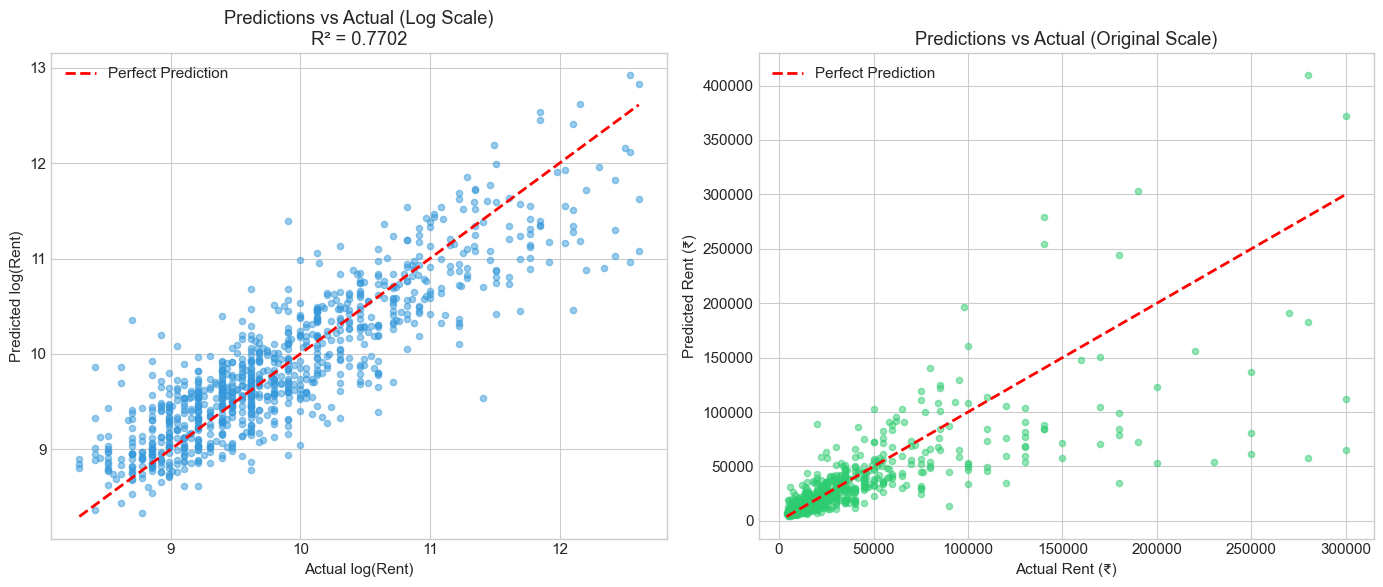

In [266]:
# Predictions vs Actual visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Log scale
axes[0].scatter(y_test, y_test_pred_log, alpha=0.5, c='#3498db', s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual log(Rent)')
axes[0].set_ylabel('Predicted log(Rent)')
axes[0].set_title(f'Predictions vs Actual (Log Scale)\nR² = {r2_test:.4f}')
axes[0].legend()

# Original scale
axes[1].scatter(y_test_actual, y_test_pred, alpha=0.5, c='#2ecc71', s=20)
axes[1].plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rent (₹)')
axes[1].set_ylabel('Predicted Rent (₹)')
axes[1].set_title('Predictions vs Actual (Original Scale)')
axes[1].legend()

plt.tight_layout()
plt.show()

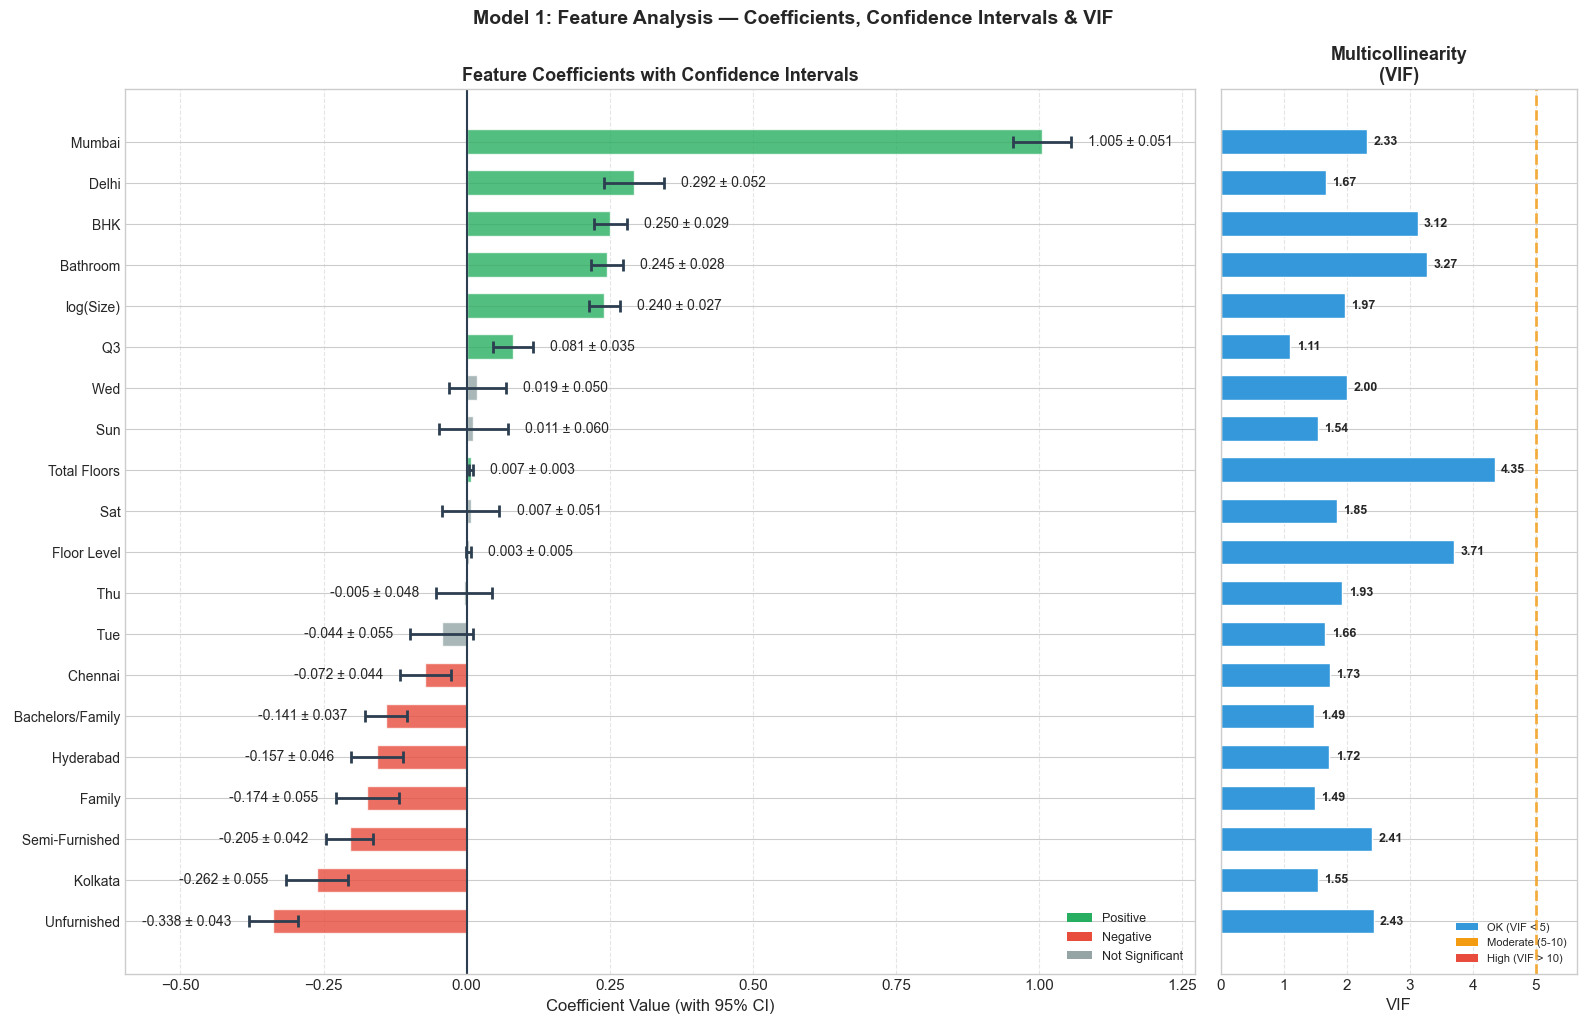


FEATURE ANALYSIS SUMMARY (Top 20 by |Coefficient|)
Feature                              Coef               95% CI      P-Value      VIF       Status
----------------------------------------------------------------------------------------------------
City: Mumbai                       1.0048       [0.954, 1.056]  9.29e-276 ***     2.33         OK
Furnishing: Unfurnished           -0.3380     [-0.381, -0.295]   3.04e-52 ***     2.43         OK
City: Delhi                        0.2919       [0.240, 0.344]   6.47e-28 ***     1.67         OK
City: Kolkata                     -0.2616     [-0.316, -0.207]   8.87e-21 ***     1.55         OK
BHK                                0.2503       [0.221, 0.279]   2.90e-62 ***     3.12         OK
Bathroom                           0.2447       [0.217, 0.273]   1.20e-62 ***     3.27         OK
log(Size)                          0.2400       [0.213, 0.267]   4.32e-65 ***     1.97         OK
Furnishing: Semi-Furnished        -0.2047     [-0.246, -0.163] 

In [267]:
# ============================================
# Enhanced Coefficient Plot with Confidence Intervals and VIF
# ============================================
import statsmodels.api as sm

# Fit OLS model with statsmodels to get confidence intervals
X_train_with_const = sm.add_constant(X_train_arr)
ols_model = sm.OLS(y_train.values, X_train_with_const).fit()

# Get coefficients and confidence intervals (excluding intercept)
coef_values = ols_model.params[1:]  # Skip intercept
conf_int = ols_model.conf_int()[1:]  # Skip intercept
std_errors = ols_model.bse[1:]  # Standard errors

# Create enhanced dataframe
# All values are numpy arrays after slicing
coef_enhanced_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef_values,
    'Std_Error': std_errors,
    'CI_Lower': conf_int[:, 0],  # numpy array indexing
    'CI_Upper': conf_int[:, 1],  # numpy array indexing
    'P_Value': ols_model.pvalues[1:]
})
coef_enhanced_df['Abs_Coefficient'] = np.abs(coef_enhanced_df['Coefficient'])

# Calculate VIF for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif_const = sm.add_constant(pd.DataFrame(X_train_arr, columns=feature_names))
vif_values = []
for i, col in enumerate(feature_names):
    try:
        vif = variance_inflation_factor(X_vif_const.values, i + 1)
        vif_values.append(vif)
    except:
        vif_values.append(np.nan)

coef_enhanced_df['VIF'] = vif_values

# Sort by absolute coefficient and get top N
top_n = 20
top_coefs_enhanced = coef_enhanced_df.nlargest(top_n, 'Abs_Coefficient').sort_values('Coefficient')

# ============================================
# Create figure with two subplots
# ============================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10), gridspec_kw={'width_ratios': [3, 1]})

# ----- Left Plot: Coefficients with Confidence Intervals -----
y_positions = np.arange(len(top_coefs_enhanced))

# Color based on significance and sign
colors = []
for _, row in top_coefs_enhanced.iterrows():
    if row['P_Value'] > 0.05:  # Not significant
        colors.append('#95a5a6')  # Gray
    elif row['Coefficient'] < 0:
        colors.append('#e74c3c')  # Red for negative
    else:
        colors.append('#27ae60')  # Green for positive

# Plot bars
bars = ax1.barh(y_positions, top_coefs_enhanced['Coefficient'], 
                color=colors, edgecolor='white', height=0.6, alpha=0.8)

# Plot confidence intervals as error bars
ax1.errorbar(top_coefs_enhanced['Coefficient'], y_positions,
             xerr=[top_coefs_enhanced['Coefficient'] - top_coefs_enhanced['CI_Lower'],
                   top_coefs_enhanced['CI_Upper'] - top_coefs_enhanced['Coefficient']],
             fmt='none', ecolor='#2c3e50', elinewidth=2, capsize=4, capthick=2)

# Add coefficient values as labels with CI (format: coef ± CI)
for i, (idx, row) in enumerate(top_coefs_enhanced.iterrows()):
    val = row['Coefficient']
    ci_half = (row['CI_Upper'] - row['CI_Lower']) / 2  # Half-width of CI
    # Larger offset to avoid overlap with CI error bars
    x_pos = row['CI_Upper'] + 0.03 if val >= 0 else row['CI_Lower'] - 0.03
    ha = 'left' if val >= 0 else 'right'
    ax1.text(x_pos, i, f'{val:.3f} ± {ci_half:.3f}', va='center', ha=ha, fontsize=10, )

# Styling for left plot
ax1.axvline(x=0, color='#2c3e50', linestyle='-', linewidth=1.5)
ax1.set_yticks(y_positions)
ax1.set_yticklabels([n.split(':')[-1] for n in top_coefs_enhanced['Feature']], fontsize=10)
ax1.set_xlabel('Coefficient Value (with 95% CI)', fontsize=12)
ax1.set_title('Feature Coefficients with Confidence Intervals', 
              fontsize=13, fontweight='bold')
# Add margins to prevent text clipping
ax1.margins(x=0.15)
ax1.grid(axis='x', linestyle='--', alpha=0.5)

# Legend for coefficient sign
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#27ae60', label='Positive'),
    Patch(facecolor='#e74c3c', label='Negative'),
    Patch(facecolor='#95a5a6', label='Not Significant')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=9)

# ----- Right Plot: VIF Values -----
vif_colors = []
for vif in top_coefs_enhanced['VIF']:
    if pd.isna(vif) or np.isinf(vif):
        vif_colors.append('#95a5a6')
    elif vif > 10:
        vif_colors.append('#e74c3c')
    elif vif > 5:
        vif_colors.append('#f39c12')
    else:
        vif_colors.append('#3498db')

ax2.barh(y_positions, top_coefs_enhanced['VIF'], color=vif_colors, edgecolor='white', height=0.6)

# Add VIF threshold lines
ax2.axvline(x=5, color='#f39c12', linestyle='--', linewidth=2, alpha=0.8)
ax2.axvline(x=10, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.8)

# Add VIF values as labels
for i, vif in enumerate(top_coefs_enhanced['VIF']):
    if not (pd.isna(vif) or np.isinf(vif)):
        ax2.text(vif + 0.1, i, f'{vif:.2f}', va='center', ha='left', fontsize=9, fontweight='bold')

# Styling for right plot
ax2.set_yticks(y_positions)
ax2.set_yticklabels([])  # Hide y-labels (shared with left plot)
ax2.set_xlabel('VIF', fontsize=12)
ax2.set_title('Multicollinearity\n(VIF)', fontsize=13, fontweight='bold')
ax2.set_xlim(0, max(top_coefs_enhanced['VIF']) * 1.3)
ax2.grid(axis='x', linestyle='--', alpha=0.5)

# VIF Legend
vif_legend = [
    Patch(facecolor='#3498db', label='OK (VIF < 5)'),
    Patch(facecolor='#f39c12', label='Moderate (5-10)'),
    Patch(facecolor='#e74c3c', label='High (VIF > 10)')
]
ax2.legend(handles=vif_legend, loc='lower right', fontsize=8)

plt.tight_layout()
plt.suptitle('Model 1: Feature Analysis — Coefficients, Confidence Intervals & VIF', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Print summary table
print("\n" + "=" * 100)
print("FEATURE ANALYSIS SUMMARY (Top 20 by |Coefficient|)")
print("=" * 100)
print(f"{'Feature':<30} {'Coef':>10} {'95% CI':>20} {'P-Value':>12} {'VIF':>8} {'Status':>12}")
print("-" * 100)
for _, row in top_coefs_enhanced.sort_values('Abs_Coefficient', ascending=False).iterrows():
    sig = '***' if row['P_Value'] < 0.001 else '**' if row['P_Value'] < 0.01 else '*' if row['P_Value'] < 0.05 else 'ns'
    vif_status = 'HIGH' if row['VIF'] > 10 else 'Moderate' if row['VIF'] > 5 else 'OK'
    ci_str = f"[{row['CI_Lower']:.3f}, {row['CI_Upper']:.3f}]"
    print(f"{row['Feature']:<30} {row['Coefficient']:>10.4f} {ci_str:>20} {row['P_Value']:>10.2e} {sig:>2} {row['VIF']:>8.2f} {vif_status:>10}")


---

## 6. Model 2: Linear Regression with Feature Combinations

**Model 2** uses the same preprocessing pipeline but with feature interactions:
- Combines: City × Quarter × Tenant Preferred
- `keep_originals=False`: Replaces original columns with combined features


In [268]:
# ============================================
# Model 2: Preprocessing with Feature Combinations
# ============================================
print("=" * 80)
print("MODEL 2: Linear Regression with Feature Combinations")
print("=" * 80)
print()

# Configuration for Model 2 (with combinations)
COMBINATIONS_TO_APPLY_M2 = [
    # {'columns': ['City', 'quarter posted'], 'keep_originals': False},
]

# Model 2: Drop features with high correlation or low significance
NUMERIC_COLS_M2 = ['BHK', 'Bathroom']
CATEGORICAL_COLS_M2 = ['City', 'Furnishing Status', 'Tenant Preferred', 'quarter posted']  

print(f"Model 2 numeric features: {NUMERIC_COLS_M2}")
print(f"Model 2 categorical features: {CATEGORICAL_COLS_M2}")

# Build fresh preprocessor
num_pipeline_m2 = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

cat_pipeline_m2 = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_m2 = ColumnTransformer([
    ("log_transform", LogScaling(), LOG_SCALING_COLS),
    ("num_pipeline", num_pipeline_m2, NUMERIC_COLS_M2),  # Using reduced numeric cols
    ("cat_pipelines", cat_pipeline_m2, CATEGORICAL_COLS_M2)  # Using reduced categorical cols
], remainder='drop') 

# Fit and transform
X_train_arr_m2 = preprocessor_m2.fit_transform(X_train)
X_test_arr_m2 = preprocessor_m2.transform(X_test)
print(f"After preprocessing: {X_train_arr_m2.shape}")

# ============================================
# Get one-hot groups for combinations
# ============================================
onehot_groups_m2 = get_onehot_groups(preprocessor_m2, LOG_SCALING_COLS, NUMERIC_COLS_M2, CATEGORICAL_COLS_M2)
print(f"OneHot groups: {onehot_groups_m2}")

# ============================================
# Apply combinations
# ============================================
combiners_m2 = []
combined_groups_m2 = {}
onehot_groups_m2_copy = onehot_groups_m2.copy()

for combo_config in COMBINATIONS_TO_APPLY_M2:
    combo = combo_config['columns']
    keep_originals = combo_config.get('keep_originals', False)
    
    indices = []
    sizes = []
    for group_name in combo:
        group = onehot_groups_m2_copy[group_name]
        indices.extend(range(group['start'], group['start'] + group['size']))
        sizes.append(group['size'])
    
    print(f"Combining: {combo}, sizes={sizes}, keep_originals={keep_originals}")
    combiner = CombinedOneHotEncoder(column_indices=indices, sizes=sizes, keep_originals=keep_originals)
    X_train_arr_m2 = combiner.fit_transform(X_train_arr_m2)
    X_test_arr_m2 = combiner.transform(X_test_arr_m2)
    combiners_m2.append(combiner)
    
    combined_size = np.prod(sizes)
    combined_start = X_train_arr_m2.shape[1] - combined_size
    combined_name = ' x '.join(combo)
    combined_groups_m2[combined_name] = {'start': combined_start, 'size': combined_size}
    
    if not keep_originals:
        for group_name in combo:
            if group_name in onehot_groups_m2_copy:
                del onehot_groups_m2_copy[group_name]
        indices_set = set(indices)
        for name, group in onehot_groups_m2_copy.items():
            removed_before = sum(1 for idx in indices_set if idx < group['start'])
            group['start'] = group['start'] - removed_before
        for name, group in combined_groups_m2.items():
            if name != combined_name:
                removed_before = sum(1 for idx in indices_set if idx < group['start'])
                group['start'] = group['start'] - removed_before
    
    print(f"After combining: shape={X_train_arr_m2.shape}")

# ============================================
# Drop first column from each one-hot group (dummy variable trap)
# ============================================
all_groups_m2 = {**onehot_groups_m2_copy, **combined_groups_m2}
columns_to_drop_m2 = [group['start'] for group in all_groups_m2.values()]
columns_to_drop_m2 = sorted(columns_to_drop_m2, reverse=True)

for col_idx in columns_to_drop_m2:
    X_train_arr_m2 = np.delete(X_train_arr_m2, col_idx, axis=1)
    X_test_arr_m2 = np.delete(X_test_arr_m2, col_idx, axis=1)

print(f"After dropping first of each group: {X_train_arr_m2.shape}")

# ============================================
# Generate feature names for Model 2
# ============================================
ohe_m2 = preprocessor_m2.named_transformers_['cat_pipelines'].named_steps['one_hot_encoder']
cat_col_to_categories_m2 = dict(zip(CATEGORICAL_COLS_M2, ohe_m2.categories_))

feature_names_m2 = []
feature_names_m2.extend([f'log({col})' for col in LOG_SCALING_COLS])
feature_names_m2.extend(NUMERIC_COLS_M2)  # Using reduced numeric cols (no Floor Level, Total Floors)

# Remaining one-hot groups (not combined)
removed_cols_m2 = [item for combo_config in COMBINATIONS_TO_APPLY_M2 
                   for item in combo_config['columns'] 
                   if not combo_config.get('keep_originals', False)]
remaining_cat_cols_m2 = [c for c in CATEGORICAL_COLS_M2 if c not in removed_cols_m2]

for col in remaining_cat_cols_m2:
    categories = cat_col_to_categories_m2[col]
    short_col = prettify_col_name(col)
    for cat in categories[1:]:  # Skip first (dropped for dummy trap)
        pretty_val = prettify_value(col, cat)
        feature_names_m2.append(f'{short_col}: {pretty_val}')

# Combined group names
for combo_config in COMBINATIONS_TO_APPLY_M2:
    combo = combo_config['columns']
    combo_categories = [cat_col_to_categories_m2[c] for c in combo]
    all_combos = list(product(*combo_categories))
    for combo_vals in all_combos[1:]:  # Skip first
        parts = []
        for c, v in zip(combo, combo_vals):
            short_col = prettify_col_name(c)
            pretty_val = prettify_value(c, v)
            parts.append(f'{short_col}={pretty_val}')
        feature_names_m2.append(' & '.join(parts))

print(f"\nTotal features Model 2: {len(feature_names_m2)}")
print(f"Feature names: {feature_names_m2[:10]}... (showing first 10)")


MODEL 2: Linear Regression with Feature Combinations

Model 2 numeric features: ['BHK', 'Bathroom']
Model 2 categorical features: ['City', 'Furnishing Status', 'Tenant Preferred', 'quarter posted']
After preprocessing: (3736, 17)
OneHot groups: {'City': {'start': 3, 'size': 6}, 'Furnishing Status': {'start': 9, 'size': 3}, 'Tenant Preferred': {'start': 12, 'size': 3}, 'quarter posted': {'start': 15, 'size': 2}}
After dropping first of each group: (3736, 13)

Total features Model 2: 13
Feature names: ['log(Size)', 'BHK', 'Bathroom', 'City: Chennai', 'City: Delhi', 'City: Hyderabad', 'City: Kolkata', 'City: Mumbai', 'Furnishing: Semi-Furnished', 'Furnishing: Unfurnished']... (showing first 10)


In [269]:
# ============================================
# Train Linear Regression - Model 2
# ============================================
model_m2 = LinearRegression()
model_m2.fit(X_train_arr_m2, y_train.values)

# Predictions (log scale)
y_train_pred_log_m2 = model_m2.predict(X_train_arr_m2)
y_test_pred_log_m2 = model_m2.predict(X_test_arr_m2)

# Convert to original scale
y_train_pred_m2 = np.exp(y_train_pred_log_m2)
y_test_pred_m2 = np.exp(y_test_pred_log_m2)
y_train_actual_m2 = np.exp(y_train)
y_test_actual_m2 = np.exp(y_test)

# ============================================
# Calculate Metrics - Model 2
# ============================================

# R² (on log scale)
r2_train_m2 = r2_score(y_train, y_train_pred_log_m2)
r2_test_m2 = r2_score(y_test, y_test_pred_log_m2)

# RMSE (on original scale)
rmse_train_m2 = np.sqrt(mean_squared_error(y_train_actual_m2, y_train_pred_m2))
rmse_test_m2 = np.sqrt(mean_squared_error(y_test_actual_m2, y_test_pred_m2))

# MAE (on original scale)
mae_train_m2 = mean_absolute_error(y_train_actual_m2, y_train_pred_m2)
mae_test_m2 = mean_absolute_error(y_test_actual_m2, y_test_pred_m2)

# RMSPE
rmspe_train_m2 = rmspe(y_train_actual_m2, y_train_pred_m2)
rmspe_test_m2 = rmspe(y_test_actual_m2, y_test_pred_m2)

# MAPE
mape_train_m2 = mape(y_train_actual_m2, y_train_pred_m2)
mape_test_m2 = mape(y_test_actual_m2, y_test_pred_m2)

# Print Results
print("=" * 80)
print("MODEL 2 PERFORMANCE METRICS")
print("=" * 80)
print()
print(f"{'Metric':<20} {'Train':<15} {'Test':<15}")
print("-" * 50)
print(f"{'R²':<20} {r2_train_m2:<15.4f} {r2_test_m2:<15.4f}")
print(f"{'RMSE (₹)':<20} {rmse_train_m2:<15,.0f} {rmse_test_m2:<15,.0f}")
print(f"{'MAE (₹)':<20} {mae_train_m2:<15,.0f} {mae_test_m2:<15,.0f}")
print(f"{'RMSPE (%)':<20} {rmspe_train_m2:<15.2f} {rmspe_test_m2:<15.2f}")
print(f"{'MAPE (%)':<20} {mape_train_m2:<15.2f} {mape_test_m2:<15.2f}")


MODEL 2 PERFORMANCE METRICS

Metric               Train           Test           
--------------------------------------------------
R²                   0.7716          0.7644         
RMSE (₹)             22,786          25,446         
MAE (₹)              10,568          11,378         
RMSPE (%)            50.76           50.44          
MAPE (%)             33.84           34.50          


### 6.3 Predictions vs Actual - Model 2


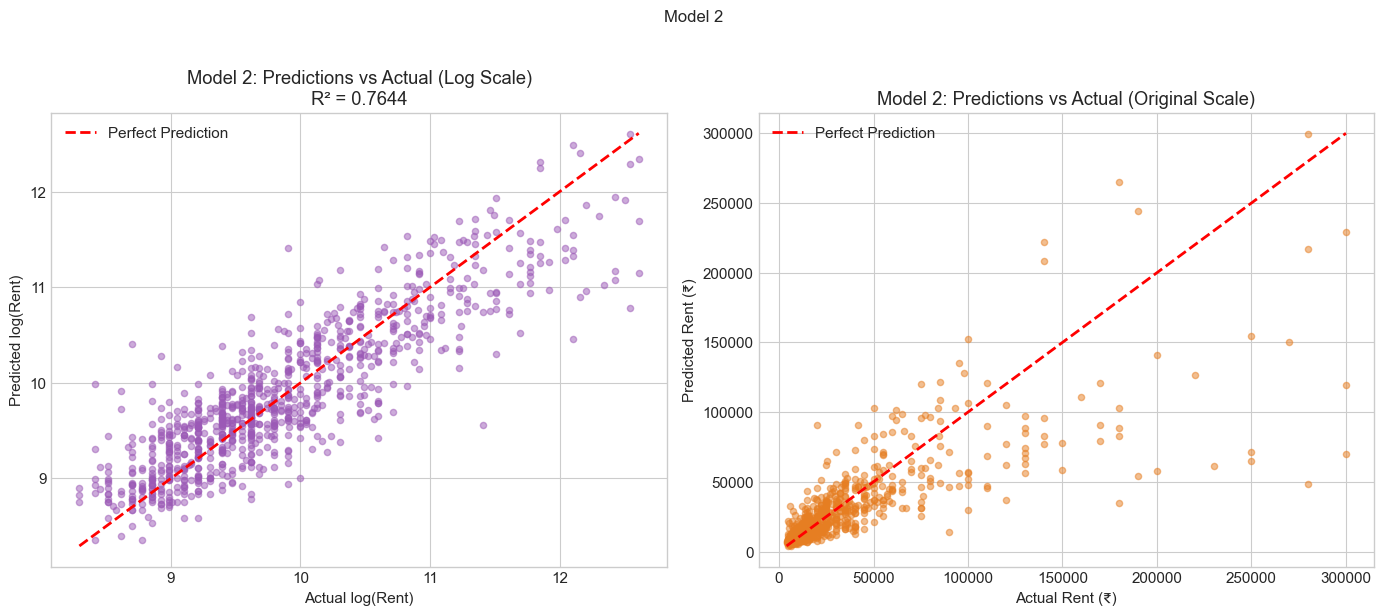

In [270]:
# Predictions vs Actual visualization - Model 2
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Log scale
axes[0].scatter(y_test, y_test_pred_log_m2, alpha=0.5, c='#9b59b6', s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual log(Rent)')
axes[0].set_ylabel('Predicted log(Rent)')
axes[0].set_title(f'Model 2: Predictions vs Actual (Log Scale)\nR² = {r2_test_m2:.4f}')
axes[0].legend()

# Original scale
axes[1].scatter(y_test_actual_m2, y_test_pred_m2, alpha=0.5, c='#e67e22', s=20)
axes[1].plot([y_test_actual_m2.min(), y_test_actual_m2.max()], [y_test_actual_m2.min(), y_test_actual_m2.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rent (₹)')
axes[1].set_ylabel('Predicted Rent (₹)')
axes[1].set_title('Model 2: Predictions vs Actual (Original Scale)')
axes[1].legend()

plt.suptitle('Model 2', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


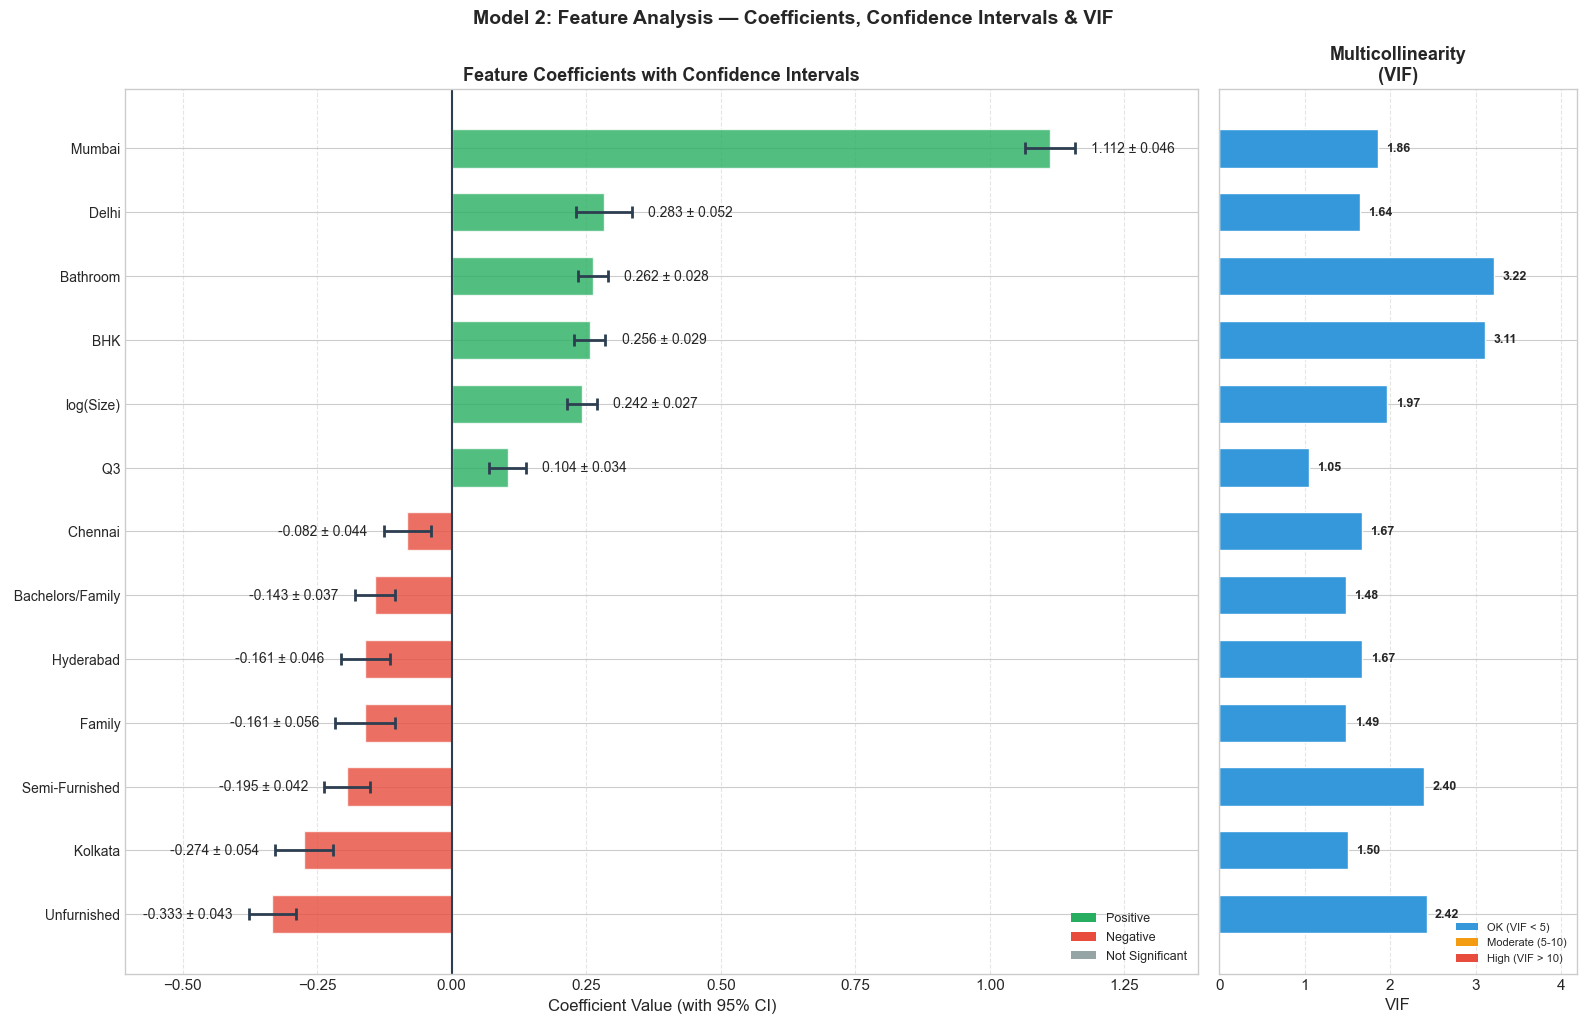


FEATURE ANALYSIS SUMMARY (Top 20 by |Coefficient|)
Feature                              Coef               95% CI      P-Value      VIF       Status
----------------------------------------------------------------------------------------------------
City: Mumbai                       1.1116       [1.066, 1.158]   0.00e+00 ***     1.86         OK
Furnishing: Unfurnished           -0.3333     [-0.377, -0.290]   7.78e-50 ***     2.42         OK
City: Delhi                        0.2826       [0.231, 0.335]   5.09e-26 ***     1.64         OK
City: Kolkata                     -0.2743     [-0.329, -0.220]   9.93e-23 ***     1.50         OK
Bathroom                           0.2620       [0.234, 0.290]   1.06e-70 ***     3.22         OK
BHK                                0.2564       [0.227, 0.286]   7.04e-64 ***     3.11         OK
log(Size)                          0.2423       [0.215, 0.270]   5.53e-65 ***     1.97         OK
Furnishing: Semi-Furnished        -0.1945     [-0.237, -0.153] 

In [271]:
# ============================================
# Enhanced Coefficient Plot with Confidence Intervals and VIF - Model 2
# ============================================
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.patches import Patch

# Fit OLS model with statsmodels to get confidence intervals
X_train_with_const_m2 = sm.add_constant(X_train_arr_m2)
ols_model_m2 = sm.OLS(y_train.values, X_train_with_const_m2).fit()

# Get coefficients and confidence intervals (excluding intercept)
coef_values_m2 = ols_model_m2.params[1:]  # Skip intercept
conf_int_m2 = ols_model_m2.conf_int()[1:]  # Skip intercept
std_errors_m2 = ols_model_m2.bse[1:]  # Standard errors

# Create enhanced dataframe
coef_enhanced_df_m2 = pd.DataFrame({
    'Feature': feature_names_m2,
    'Coefficient': coef_values_m2,
    'Std_Error': std_errors_m2,
    'CI_Lower': conf_int_m2[:, 0],
    'CI_Upper': conf_int_m2[:, 1],
    'P_Value': ols_model_m2.pvalues[1:]
})
coef_enhanced_df_m2['Abs_Coefficient'] = np.abs(coef_enhanced_df_m2['Coefficient'])

# Calculate VIF for each feature
X_vif_const_m2 = sm.add_constant(pd.DataFrame(X_train_arr_m2, columns=feature_names_m2))
vif_values_m2 = []
for i, col in enumerate(feature_names_m2):
    try:
        vif = variance_inflation_factor(X_vif_const_m2.values, i + 1)
        vif_values_m2.append(vif)
    except:
        vif_values_m2.append(np.nan)

coef_enhanced_df_m2['VIF'] = vif_values_m2

# Sort by absolute coefficient and get top N
top_n_m2 = 20
top_coefs_enhanced_m2 = coef_enhanced_df_m2.nlargest(top_n_m2, 'Abs_Coefficient').sort_values('Coefficient')

# ============================================
# Create figure with two subplots
# ============================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10), gridspec_kw={'width_ratios': [3, 1]})

# ----- Left Plot: Coefficients with Confidence Intervals -----
y_positions = np.arange(len(top_coefs_enhanced_m2))

# Color based on significance and sign
colors = []
for _, row in top_coefs_enhanced_m2.iterrows():
    if row['P_Value'] > 0.05:
        colors.append('#95a5a6')
    elif row['Coefficient'] < 0:
        colors.append('#e74c3c')
    else:
        colors.append('#27ae60')

# Plot bars
bars = ax1.barh(y_positions, top_coefs_enhanced_m2['Coefficient'], 
                color=colors, edgecolor='white', height=0.6, alpha=0.8)

# Plot confidence intervals as error bars
ax1.errorbar(top_coefs_enhanced_m2['Coefficient'], y_positions,
             xerr=[top_coefs_enhanced_m2['Coefficient'] - top_coefs_enhanced_m2['CI_Lower'],
                   top_coefs_enhanced_m2['CI_Upper'] - top_coefs_enhanced_m2['Coefficient']],
             fmt='none', ecolor='#2c3e50', elinewidth=2, capsize=4, capthick=2)

# Add coefficient values as labels with CI (format: coef ± CI)
for i, (idx, row) in enumerate(top_coefs_enhanced_m2.iterrows()):
    val = row['Coefficient']
    ci_half = (row['CI_Upper'] - row['CI_Lower']) / 2
    x_pos = row['CI_Upper'] + 0.03 if val >= 0 else row['CI_Lower'] - 0.03
    ha = 'left' if val >= 0 else 'right'
    ax1.text(x_pos, i, f'{val:.3f} ± {ci_half:.3f}', va='center', ha=ha, fontsize=10)

# Styling for left plot
ax1.axvline(x=0, color='#2c3e50', linestyle='-', linewidth=1.5)
ax1.set_yticks(y_positions)
ax1.set_yticklabels([n.split(':')[-1] for n in top_coefs_enhanced_m2['Feature']], fontsize=10)
ax1.set_xlabel('Coefficient Value (with 95% CI)', fontsize=12)
ax1.set_title('Feature Coefficients with Confidence Intervals', fontsize=13, fontweight='bold')
ax1.margins(x=0.15)
ax1.grid(axis='x', linestyle='--', alpha=0.5)

# Legend for coefficient sign
legend_elements = [
    Patch(facecolor='#27ae60', label='Positive'),
    Patch(facecolor='#e74c3c', label='Negative'),
    Patch(facecolor='#95a5a6', label='Not Significant')
]
ax1.legend(handles=legend_elements, loc='lower right', fontsize=9)

# ----- Right Plot: VIF Values -----
vif_colors = []
for vif in top_coefs_enhanced_m2['VIF']:
    if pd.isna(vif) or np.isinf(vif):
        vif_colors.append('#95a5a6')
    elif vif > 10:
        vif_colors.append('#e74c3c')
    elif vif > 5:
        vif_colors.append('#f39c12')
    else:
        vif_colors.append('#3498db')

ax2.barh(y_positions, top_coefs_enhanced_m2['VIF'], color=vif_colors, edgecolor='white', height=0.6)

# Add VIF threshold lines
ax2.axvline(x=5, color='#f39c12', linestyle='--', linewidth=2, alpha=0.8)
ax2.axvline(x=10, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.8)

# Add VIF values as labels
for i, vif in enumerate(top_coefs_enhanced_m2['VIF']):
    if not (pd.isna(vif) or np.isinf(vif)):
        ax2.text(vif + 0.1, i, f'{vif:.2f}', va='center', ha='left', fontsize=9, fontweight='bold')

# Styling for right plot
ax2.set_yticks(y_positions)
ax2.set_yticklabels([])
ax2.set_xlabel('VIF', fontsize=12)
ax2.set_title('Multicollinearity\n(VIF)', fontsize=13, fontweight='bold')
ax2.set_xlim(0, max(top_coefs_enhanced_m2['VIF'].dropna()) * 1.3 if not top_coefs_enhanced_m2['VIF'].isna().all() else 10)
ax2.grid(axis='x', linestyle='--', alpha=0.5)

# VIF Legend
vif_legend = [
    Patch(facecolor='#3498db', label='OK (VIF < 5)'),
    Patch(facecolor='#f39c12', label='Moderate (5-10)'),
    Patch(facecolor='#e74c3c', label='High (VIF > 10)')
]
ax2.legend(handles=vif_legend, loc='lower right', fontsize=8)

plt.tight_layout()
plt.suptitle('Model 2: Feature Analysis — Coefficients, Confidence Intervals & VIF', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Print summary table
print("\n" + "=" * 100)
print("FEATURE ANALYSIS SUMMARY (Top 20 by |Coefficient|)")
print("=" * 100)
print(f"{'Feature':<30} {'Coef':>10} {'95% CI':>20} {'P-Value':>12} {'VIF':>8} {'Status':>12}")
print("-" * 100)
for _, row in top_coefs_enhanced_m2.sort_values('Abs_Coefficient', ascending=False).iterrows():
    sig = '***' if row['P_Value'] < 0.001 else '**' if row['P_Value'] < 0.01 else '*' if row['P_Value'] < 0.05 else 'ns'
    vif_status = 'HIGH' if row['VIF'] > 10 else 'Moderate' if row['VIF'] > 5 else 'OK'
    ci_str = f"[{row['CI_Lower']:.3f}, {row['CI_Upper']:.3f}]"
    print(f"{row['Feature']:<30} {row['Coefficient']:>10.4f} {ci_str:>20} {row['P_Value']:>10.2e} {sig:>2} {row['VIF']:>8.2f} {vif_status:>10}")


---

## 7. Model Comparison: Model 1 vs Model 2



MODEL COMPARISON: Model 1 (Basic) vs Model 2

         Metric Model 1 (Basic) Model 2 (Combinations)
     R² (Train)          0.7776                 0.7716
      R² (Test)          0.7702                 0.7644
 RMSE Train (₹)          22,987                 22,786
  RMSE Test (₹)          26,439                 25,446
  MAE Train (₹)          10,498                 10,568
   MAE Test (₹)          11,517                 11,378
RMSPE Train (%)           48.91                  50.76
 RMSPE Test (%)           48.87                  50.44
 MAPE Train (%)           33.21                  33.84
  MAPE Test (%)           33.92                  34.50
   Num Features              21                     13


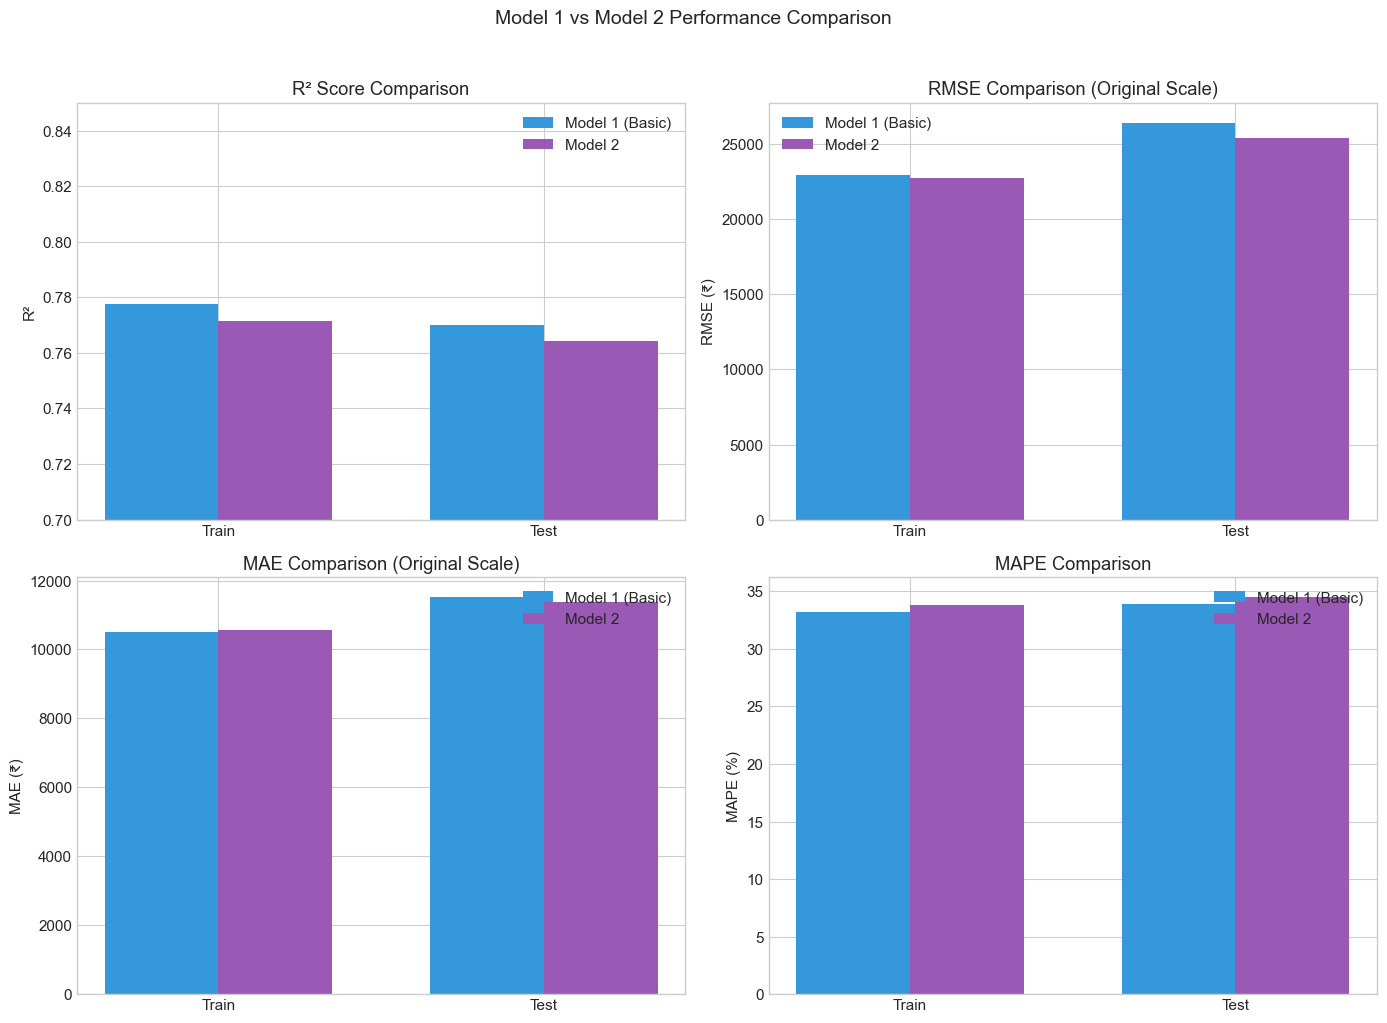


SUMMARY

Model 2 vs Model 1 (Test Set):
  R² difference: -0.0058 (worse)
  RMSE difference: -993 ₹ (better)
  MAE difference: -139 ₹ (better)

Model 1 features: 21
Model 2 features: 13


In [272]:
# ============================================
# Model Comparison Table
# ============================================
print("=" * 90)
print("MODEL COMPARISON: Model 1 (Basic) vs Model 2")
print("=" * 90)
print()

comparison_data = {
    'Metric': ['R² (Train)', 'R² (Test)', 'RMSE Train (₹)', 'RMSE Test (₹)', 
               'MAE Train (₹)', 'MAE Test (₹)', 'RMSPE Train (%)', 'RMSPE Test (%)',
               'MAPE Train (%)', 'MAPE Test (%)', 'Num Features'],
    'Model 1 (Basic)': [
        f'{r2_train:.4f}', f'{r2_test:.4f}', 
        f'{rmse_train:,.0f}', f'{rmse_test:,.0f}',
        f'{mae_train:,.0f}', f'{mae_test:,.0f}',
        f'{rmspe_train:.2f}', f'{rmspe_test:.2f}',
        f'{mape_train:.2f}', f'{mape_test:.2f}',
        f'{len(feature_names)}'
    ],
    'Model 2 (Combinations)': [
        f'{r2_train_m2:.4f}', f'{r2_test_m2:.4f}',
        f'{rmse_train_m2:,.0f}', f'{rmse_test_m2:,.0f}',
        f'{mae_train_m2:,.0f}', f'{mae_test_m2:,.0f}',
        f'{rmspe_train_m2:.2f}', f'{rmspe_test_m2:.2f}',
        f'{mape_train_m2:.2f}', f'{mape_test_m2:.2f}',
        f'{len(feature_names_m2)}'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Comparison chart
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# R² comparison
metrics_r2 = ['Train', 'Test']
model1_r2 = [r2_train, r2_test]
model2_r2 = [r2_train_m2, r2_test_m2]

x = np.arange(len(metrics_r2))
width = 0.35

axes[0, 0].bar(x - width/2, model1_r2, width, label='Model 1 (Basic)', color='#3498db')
axes[0, 0].bar(x + width/2, model2_r2, width, label='Model 2 ', color='#9b59b6')
axes[0, 0].set_ylabel('R²')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_r2)
axes[0, 0].legend()
axes[0, 0].set_ylim(0.7, 0.85)

# RMSE comparison
model1_rmse = [rmse_train, rmse_test]
model2_rmse = [rmse_train_m2, rmse_test_m2]

axes[0, 1].bar(x - width/2, model1_rmse, width, label='Model 1 (Basic)', color='#3498db')
axes[0, 1].bar(x + width/2, model2_rmse, width, label='Model 2 ', color='#9b59b6')
axes[0, 1].set_ylabel('RMSE (₹)')
axes[0, 1].set_title('RMSE Comparison (Original Scale)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_r2)
axes[0, 1].legend()

# MAE comparison
model1_mae = [mae_train, mae_test]
model2_mae = [mae_train_m2, mae_test_m2]

axes[1, 0].bar(x - width/2, model1_mae, width, label='Model 1 (Basic)', color='#3498db')
axes[1, 0].bar(x + width/2, model2_mae, width, label='Model 2 ', color='#9b59b6')
axes[1, 0].set_ylabel('MAE (₹)')
axes[1, 0].set_title('MAE Comparison (Original Scale)')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_r2)
axes[1, 0].legend()

# MAPE comparison
model1_mape = [mape_train, mape_test]
model2_mape = [mape_train_m2, mape_test_m2]

axes[1, 1].bar(x - width/2, model1_mape, width, label='Model 1 (Basic)', color='#3498db')
axes[1, 1].bar(x + width/2, model2_mape, width, label='Model 2 ', color='#9b59b6')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].set_title('MAPE Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_r2)
axes[1, 1].legend()

plt.suptitle('Model 1 vs Model 2 Performance Comparison', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 90)
print("SUMMARY")
print("=" * 90)
r2_diff = r2_test_m2 - r2_test
rmse_diff = rmse_test_m2 - rmse_test
mae_diff = mae_test_m2 - mae_test

print(f"\nModel 2 vs Model 1 (Test Set):")
print(f"  R² difference: {r2_diff:+.4f} ({'better' if r2_diff > 0 else 'worse'})")
print(f"  RMSE difference: {rmse_diff:+,.0f} ₹ ({'worse' if rmse_diff > 0 else 'better'})")
print(f"  MAE difference: {mae_diff:+,.0f} ₹ ({'worse' if mae_diff > 0 else 'better'})")
print(f"\nModel 1 features: {len(feature_names)}")
print(f"Model 2 features: {len(feature_names_m2)}")


---

## 8. Model 3: XGBoost Regressor

**Model 3** uses XGBoost (Extreme Gradient Boosting) - a powerful ensemble method based on gradient boosted decision trees.
- Uses the same features as Model 1 (basic preprocessing without combinations)
- Non-linear model capable of capturing complex patterns


In [277]:
# ============================================
# Model 3: XGBoost Regressor (Same Features as Model 2)
# ============================================
from xgboost import XGBRegressor

print("=" * 80)
print("MODEL 3: XGBoost Regressor (Same 13 Features as Model 2)")
print("=" * 80)
print()

# Use the same features as Model 2 (no Floor Level, Total Floors, Day of Week)
X_train_xgb = X_train_arr_m2
X_test_xgb = X_test_arr_m2
reduced_feature_names_xgb = feature_names_m2

print(f"Features used: {len(reduced_feature_names_xgb)}")
print(f"Features: {reduced_feature_names_xgb}")
print()

# Train XGBoost
print("Training XGBoost...")
model_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model_xgb.fit(X_train_xgb, y_train.values)

# Predictions (log scale)
y_train_pred_log_xgb = model_xgb.predict(X_train_xgb)
y_test_pred_log_xgb = model_xgb.predict(X_test_xgb)

# Convert to original scale
y_train_pred_xgb = np.exp(y_train_pred_log_xgb)
y_test_pred_xgb = np.exp(y_test_pred_log_xgb)

# ============================================
# Calculate Metrics
# ============================================
r2_train_xgb = r2_score(y_train, y_train_pred_log_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_log_xgb)

rmse_train_xgb = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_xgb))
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_xgb))

mae_train_xgb = mean_absolute_error(y_train_actual, y_train_pred_xgb)
mae_test_xgb = mean_absolute_error(y_test_actual, y_test_pred_xgb)

rmspe_train_xgb = rmspe(y_train_actual, y_train_pred_xgb)
rmspe_test_xgb = rmspe(y_test_actual, y_test_pred_xgb)

mape_train_xgb = mape(y_train_actual, y_train_pred_xgb)
mape_test_xgb = mape(y_test_actual, y_test_pred_xgb)

# Print Results
print("=" * 60)
print("MODEL 3 PERFORMANCE METRICS")
print("=" * 60)
print()
print(f"{'Metric':<20} {'Train':<15} {'Test':<15}")
print("-" * 50)
print(f"{'R²':<20} {r2_train_xgb:<15.4f} {r2_test_xgb:<15.4f}")
print(f"{'RMSE (₹)':<20} {rmse_train_xgb:<15,.0f} {rmse_test_xgb:<15,.0f}")
print(f"{'MAE (₹)':<20} {mae_train_xgb:<15,.0f} {mae_test_xgb:<15,.0f}")
print(f"{'RMSPE (%)':<20} {rmspe_train_xgb:<15.2f} {rmspe_test_xgb:<15.2f}")
print(f"{'MAPE (%)':<20} {mape_train_xgb:<15.2f} {mape_test_xgb:<15.2f}")

MODEL 3: XGBoost Regressor (Same 13 Features as Model 2)

Features used: 13
Features: ['log(Size)', 'BHK', 'Bathroom', 'City: Chennai', 'City: Delhi', 'City: Hyderabad', 'City: Kolkata', 'City: Mumbai', 'Furnishing: Semi-Furnished', 'Furnishing: Unfurnished', 'Tenant: Bachelors/Family', 'Tenant: Family', 'Quarter: Q3']

Training XGBoost...
MODEL 3 PERFORMANCE METRICS

Metric               Train           Test           
--------------------------------------------------
R²                   0.8720          0.7978         
RMSE (₹)             14,329          22,309         
MAE (₹)              7,140           10,062         
RMSPE (%)            35.04           50.00          
MAPE (%)             24.90           32.32          



### 8.1 Predictions vs Actual - XGBoost

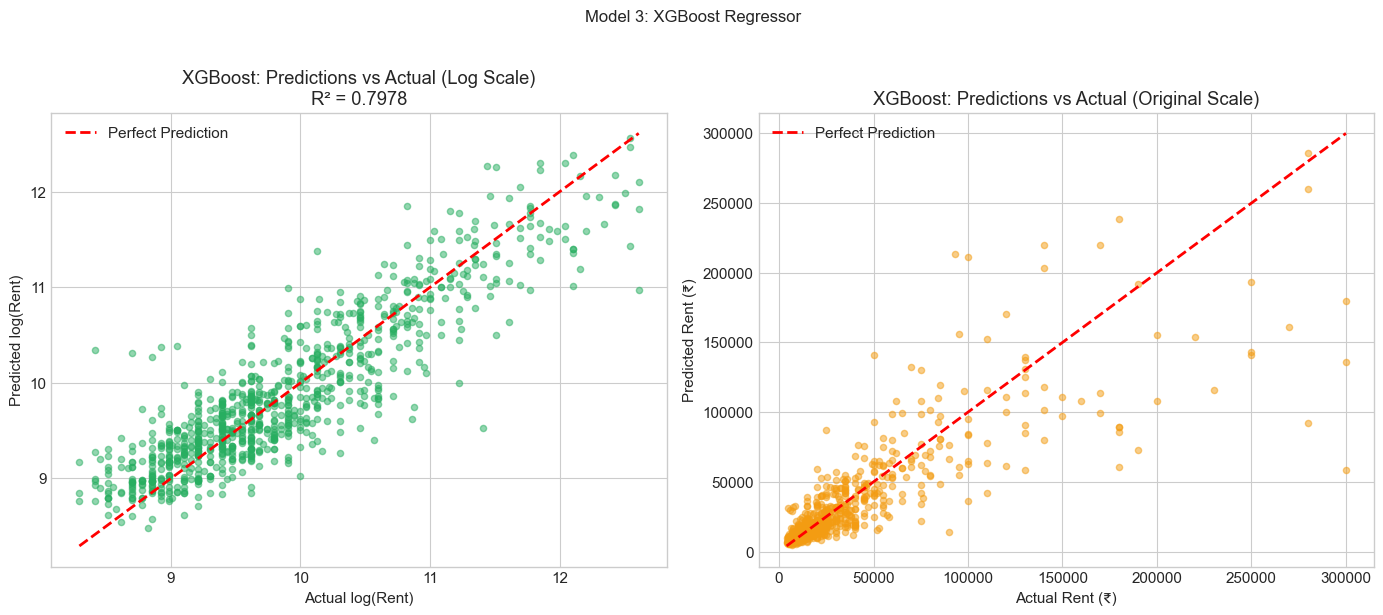

In [278]:
# Predictions vs Actual visualization - XGBoost
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Log scale
axes[0].scatter(y_test, y_test_pred_log_xgb, alpha=0.5, c='#27ae60', s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual log(Rent)')
axes[0].set_ylabel('Predicted log(Rent)')
axes[0].set_title(f'XGBoost: Predictions vs Actual (Log Scale)\nR² = {r2_test_xgb:.4f}')
axes[0].legend()

# Original scale
axes[1].scatter(y_test_actual, y_test_pred_xgb, alpha=0.5, c='#f39c12', s=20)
axes[1].plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rent (₹)')
axes[1].set_ylabel('Predicted Rent (₹)')
axes[1].set_title('XGBoost: Predictions vs Actual (Original Scale)')
axes[1].legend()

plt.suptitle('Model 3: XGBoost Regressor', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


XGBoost Feature Importance (All 13):
                   Feature  Importance
              City: Mumbai    0.708239
                  Bathroom    0.114088
                       BHK    0.052189
                 log(Size)    0.026301
               City: Delhi    0.020159
             City: Kolkata    0.017152
           City: Hyderabad    0.015212
   Furnishing: Unfurnished    0.012331
             City: Chennai    0.010503
Furnishing: Semi-Furnished    0.007208
  Tenant: Bachelors/Family    0.006163
               Quarter: Q3    0.005407
            Tenant: Family    0.005050


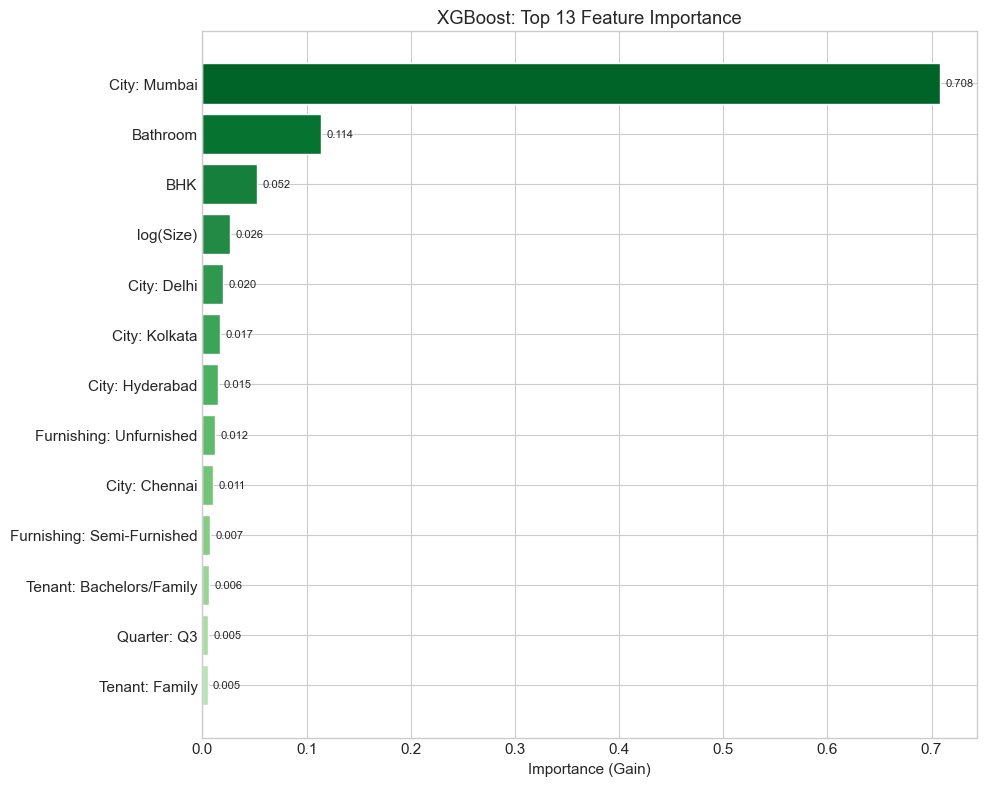

In [279]:
# XGBoost Feature Importance
importance_df = pd.DataFrame({
    'Feature': reduced_feature_names_xgb,
    'Importance': model_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

print("XGBoost Feature Importance (All 13):")
print(importance_df.head(20).to_string(index=False))

# Feature Importance bar plot
fig, ax = plt.subplots(figsize=(10, 8))

top_n_xgb = 13
top_importance = importance_df.head(top_n_xgb).sort_values('Importance')

colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(top_importance)))
bars = ax.barh(top_importance['Feature'], top_importance['Importance'], color=colors, edgecolor='white')

ax.set_xlabel('Importance (Gain)')
ax.set_title(f'XGBoost: Top {top_n_xgb} Feature Importance')

# Add value labels
for bar, val in zip(bars, top_importance['Importance']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()



---

## 9. Final Model Comparison: All 3 Models

Compare the performance of all three models:
- **Model 1**: Basic Linear Regression (21 features)
- **Model 2**: Linear Regression with City × Quarter × Tenant combinations (48 features)
- **Model 3**: XGBoost Regressor (21 features)

FINAL MODEL COMPARISON: All 3 Models

         Metric Model 1 (LR Basic) Model 2 (LR Combos) Model 3 (XGBoost)
     R² (Train)             0.7776              0.7716            0.8720
      R² (Test)             0.7702              0.7644            0.7978
 RMSE Train (₹)             22,987              22,786            14,329
  RMSE Test (₹)             26,439              25,446            22,309
  MAE Train (₹)             10,498              10,568             7,140
   MAE Test (₹)             11,517              11,378            10,062
RMSPE Train (%)              48.91               50.76             35.04
 RMSPE Test (%)              48.87               50.44             50.00
 MAPE Train (%)              33.21               33.84             24.90
  MAPE Test (%)              33.92               34.50             32.32
   Num Features                 21                  13                21
     Model Type             Linear              Linear        Tree-based


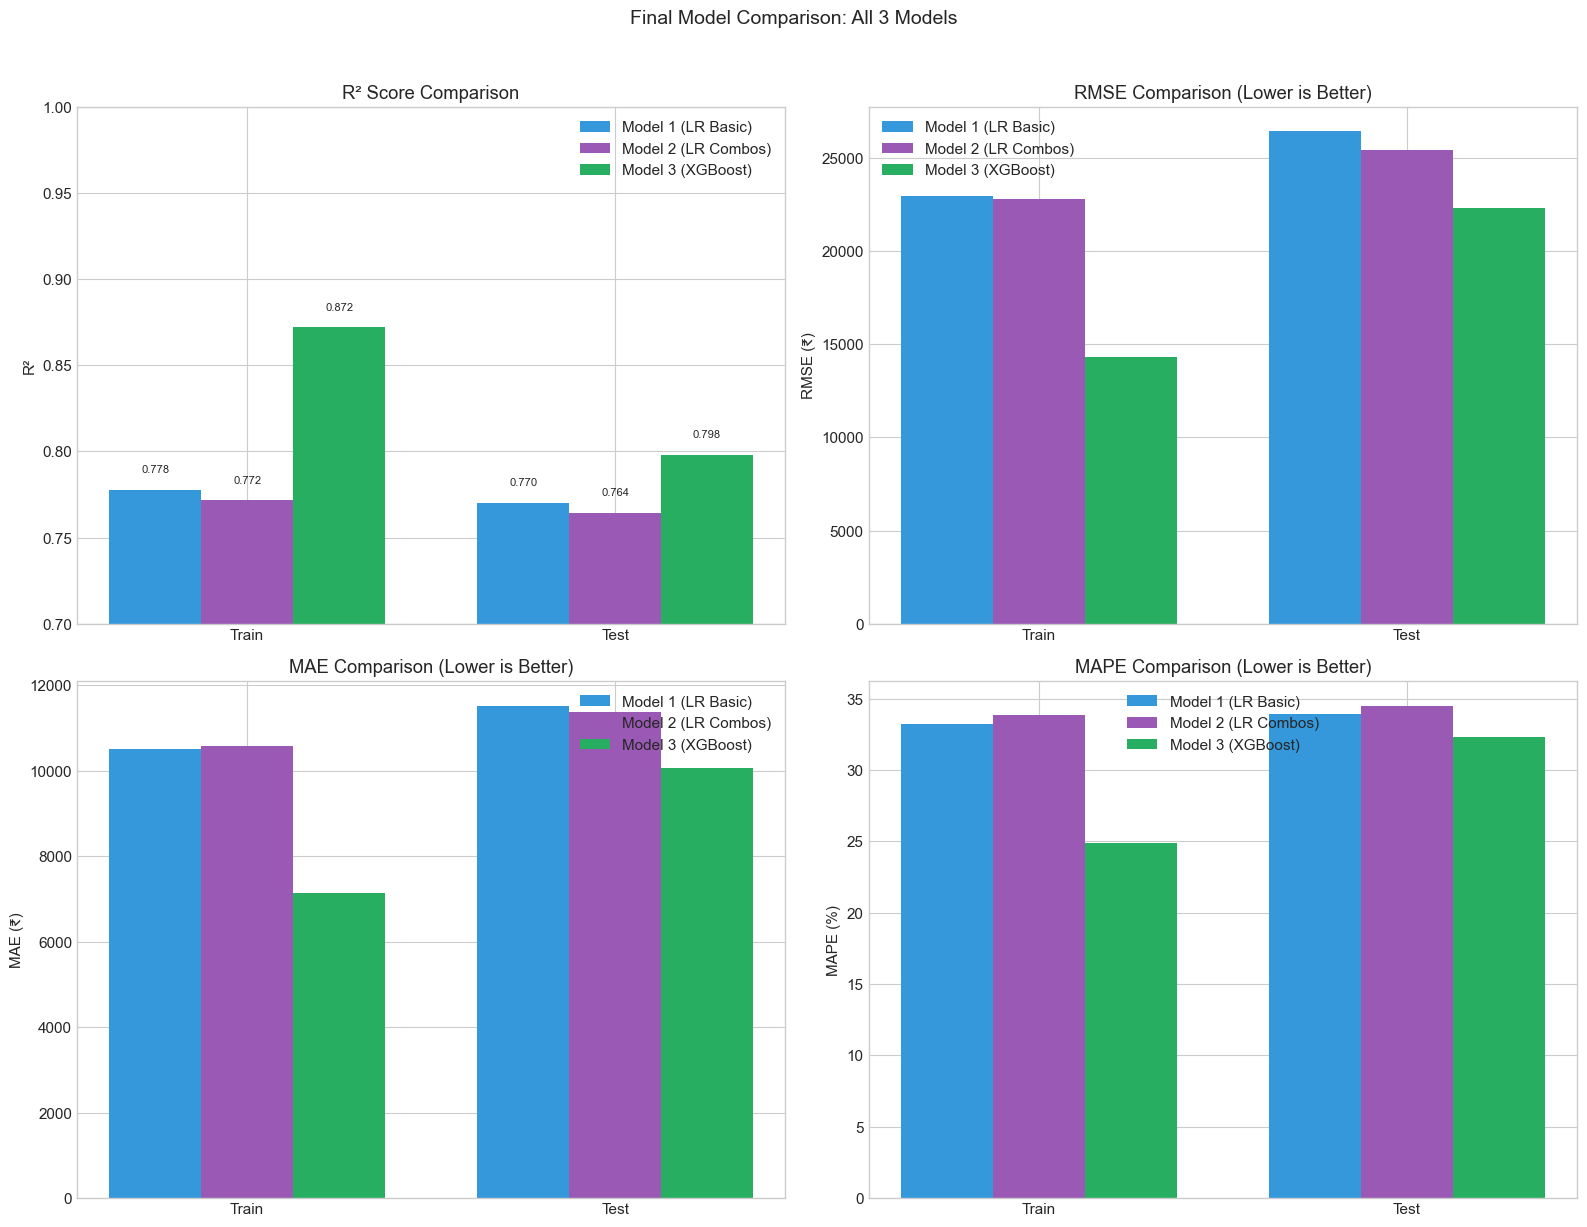

In [280]:
# ============================================
# Final Model Comparison - All 3 Models
# ============================================
print("=" * 100)
print("FINAL MODEL COMPARISON: All 3 Models")
print("=" * 100)
print()

comparison_data_final = {
    'Metric': ['R² (Train)', 'R² (Test)', 'RMSE Train (₹)', 'RMSE Test (₹)', 
               'MAE Train (₹)', 'MAE Test (₹)', 'RMSPE Train (%)', 'RMSPE Test (%)',
               'MAPE Train (%)', 'MAPE Test (%)', 'Num Features', 'Model Type'],
    'Model 1 (LR Basic)': [
        f'{r2_train:.4f}', f'{r2_test:.4f}', 
        f'{rmse_train:,.0f}', f'{rmse_test:,.0f}',
        f'{mae_train:,.0f}', f'{mae_test:,.0f}',
        f'{rmspe_train:.2f}', f'{rmspe_test:.2f}',
        f'{mape_train:.2f}', f'{mape_test:.2f}',
        f'{len(feature_names)}', 'Linear'
    ],
    'Model 2 (LR Combos)': [
        f'{r2_train_m2:.4f}', f'{r2_test_m2:.4f}',
        f'{rmse_train_m2:,.0f}', f'{rmse_test_m2:,.0f}',
        f'{mae_train_m2:,.0f}', f'{mae_test_m2:,.0f}',
        f'{rmspe_train_m2:.2f}', f'{rmspe_test_m2:.2f}',
        f'{mape_train_m2:.2f}', f'{mape_test_m2:.2f}',
        f'{len(feature_names_m2)}', 'Linear'
    ],
    'Model 3 (XGBoost)': [
        f'{r2_train_xgb:.4f}', f'{r2_test_xgb:.4f}',
        f'{rmse_train_xgb:,.0f}', f'{rmse_test_xgb:,.0f}',
        f'{mae_train_xgb:,.0f}', f'{mae_test_xgb:,.0f}',
        f'{rmspe_train_xgb:.2f}', f'{rmspe_test_xgb:.2f}',
        f'{mape_train_xgb:.2f}', f'{mape_test_xgb:.2f}',
        f'{len(feature_names)}', 'Tree-based'
    ]
}

comparison_df_final = pd.DataFrame(comparison_data_final)
print(comparison_df_final.to_string(index=False))

# ============================================
# Comparison Charts
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_labels = ['Train', 'Test']
x = np.arange(len(metrics_labels))
width = 0.25

# Colors for 3 models
colors = ['#3498db', '#9b59b6', '#27ae60']

# R² comparison
model1_r2 = [r2_train, r2_test]
model2_r2 = [r2_train_m2, r2_test_m2]
model3_r2 = [r2_train_xgb, r2_test_xgb]

axes[0, 0].bar(x - width, model1_r2, width, label='Model 1 (LR Basic)', color=colors[0])
axes[0, 0].bar(x, model2_r2, width, label='Model 2 (LR Combos)', color=colors[1])
axes[0, 0].bar(x + width, model3_r2, width, label='Model 3 (XGBoost)', color=colors[2])
axes[0, 0].set_ylabel('R²')
axes[0, 0].set_title('R² Score Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_labels)
axes[0, 0].legend()
axes[0, 0].set_ylim(0.7, 1.0)

# Add value labels
for i, (m1, m2, m3) in enumerate(zip(model1_r2, model2_r2, model3_r2)):
    axes[0, 0].text(i - width, m1 + 0.01, f'{m1:.3f}', ha='center', fontsize=8)
    axes[0, 0].text(i, m2 + 0.01, f'{m2:.3f}', ha='center', fontsize=8)
    axes[0, 0].text(i + width, m3 + 0.01, f'{m3:.3f}', ha='center', fontsize=8)

# RMSE comparison
model1_rmse = [rmse_train, rmse_test]
model2_rmse = [rmse_train_m2, rmse_test_m2]
model3_rmse = [rmse_train_xgb, rmse_test_xgb]

axes[0, 1].bar(x - width, model1_rmse, width, label='Model 1 (LR Basic)', color=colors[0])
axes[0, 1].bar(x, model2_rmse, width, label='Model 2 (LR Combos)', color=colors[1])
axes[0, 1].bar(x + width, model3_rmse, width, label='Model 3 (XGBoost)', color=colors[2])
axes[0, 1].set_ylabel('RMSE (₹)')
axes[0, 1].set_title('RMSE Comparison (Lower is Better)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_labels)
axes[0, 1].legend()

# MAE comparison
model1_mae = [mae_train, mae_test]
model2_mae = [mae_train_m2, mae_test_m2]
model3_mae = [mae_train_xgb, mae_test_xgb]

axes[1, 0].bar(x - width, model1_mae, width, label='Model 1 (LR Basic)', color=colors[0])
axes[1, 0].bar(x, model2_mae, width, label='Model 2 (LR Combos)', color=colors[1])
axes[1, 0].bar(x + width, model3_mae, width, label='Model 3 (XGBoost)', color=colors[2])
axes[1, 0].set_ylabel('MAE (₹)')
axes[1, 0].set_title('MAE Comparison (Lower is Better)')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics_labels)
axes[1, 0].legend()

# MAPE comparison
model1_mape = [mape_train, mape_test]
model2_mape = [mape_train_m2, mape_test_m2]
model3_mape = [mape_train_xgb, mape_test_xgb]

axes[1, 1].bar(x - width, model1_mape, width, label='Model 1 (LR Basic)', color=colors[0])
axes[1, 1].bar(x, model2_mape, width, label='Model 2 (LR Combos)', color=colors[1])
axes[1, 1].bar(x + width, model3_mape, width, label='Model 3 (XGBoost)', color=colors[2])
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].set_title('MAPE Comparison (Lower is Better)')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_labels)
axes[1, 1].legend()

plt.suptitle('Final Model Comparison: All 3 Models', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()